In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import logging
from sklearn.model_selection import train_test_split
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\rober\anaconda3\envs\HW7_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This function provides a flexible solution for loading different data formats.
# Dependencies: Pandas, SQLAlchemy, Python built-in libraries.
import pandas as pd
from sqlalchemy import create_engine

def load_data(source, data_format, **kwargs):
    if data_format == 'csv':
        return pd.read_csv(source, **kwargs)
    elif data_format == 'json':
        return pd.read_json(source, **kwargs)
    elif data_format == 'sql':
        engine = create_engine(source)
        return pd.read_sql_query(kwargs.get('query'), engine)
    # Extend with more data sources as needed.
    else:
        raise ValueError('Unsupported data format')

df = load_data('College_Admission_data.csv', data_format='csv', sep=',', index_col=0)

%matplotlib inline  
#if you want graphs to automatically without plt.show
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 100)

In [3]:
df = df.reset_index()
df.info(show_counts = True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 108 columns):
 #    Column                                                                                  Non-Null Count  Dtype  
---   ------                                                                                  --------------  -----  
 0    Name                                                                                    1534 non-null   object 
 1    Applicants total                                                                        1377 non-null   float64
 2    Admissions total                                                                        1377 non-null   float64
 3    Enrolled total                                                                          1377 non-null   float64
 4    Percent of freshmen submitting SAT scores                                               1257 non-null   float64
 5    Percent of freshmen submitting ACT scores                   

In [4]:
df.head()

Name  Applicants total  Admissions total  \
0             Alabama A & M University            6142.0            5521.0   
1  University of Alabama at Birmingham            5689.0            4934.0   
2                   Amridge University               NaN               NaN   
3  University of Alabama in Huntsville            2054.0            1656.0   
4             Alabama State University           10245.0            5251.0   

   Enrolled total  Percent of freshmen submitting SAT scores  \
0          1104.0                                       15.0   
1          1773.0                                        6.0   
2             NaN                                        NaN   
3           651.0                                       34.0   
4          1479.0                                       18.0   

   Percent of freshmen submitting ACT scores  \
0                                       88.0   
1                                       93.0   
2                                        NaN   
3                                       94.0   
4                                       87.0   

   SAT Critical Reading 25th percentile score  \
0                                       370.0   
1                                       520.0   
2                                         NaN   
3                                       510.0   
4                                       380.0   

   SAT Critical Reading 75th percentile score  SAT Math 25th percentile score  \
0                                       450.0                           350.0   
1                                       640.0                           520.0   
2                                         NaN                             NaN   
3                                       640.0                           510.0   
4                                       480.0                           370.0   

   SAT Math 75th percentile score  SAT Writing 25th percentile score  \
0                           450.0                                NaN   
1                           650.0                                NaN   
2                             NaN                                NaN   
3                           650.0                                NaN   
4                           480.0                                NaN   

   SAT Writing 75th percentile score  ACT Composite 25th percentile score  \
0                                NaN                                 15.0   
1                                NaN                                 22.0   
2                                NaN                                  NaN   
3                                NaN                                 23.0   
4                                NaN                                 15.0   

   ACT Composite 75th percentile score  Estimated enrollment, total  \
0                                 19.0                       5024.0   
1                                 28.0                      18568.0   
2                                  NaN                        626.0   
3                                 29.0                       7376.0   
4                                 19.0                       6076.0   

   Estimated enrollment, full time  Estimated enrollment, part time  \
0                           4442.0                            582.0   
1                          11961.0                           6607.0   
2                            326.0                            300.0   
3                           4802.0                           2574.0   
4                           5183.0                            893.0   

   Estimated undergraduate enrollment, total  \
0                                     4055.0   
1                                    11502.0   
2                                      313.0   
3                                     5696.0   
4                                     5357.0   

   Estimated undergraduate enrollment, full time  \
0                 

In [5]:
from pandas.api.types import CategoricalDtype
import warnings

def perform_eda(df, types='all', target_column='Enrolled total'):
    """
    Perform a comprehensive Exploratory Data Analysis (EDA) on the provided DataFrame.

    Parameters:
    df (DataFrame): The dataset to analyze.

    Output:
    Structured and visually appealing EDA results.
    """

    # Set display precision for floating point numbers
    pd.set_option('display.precision', 2)
    # Suppress specific warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)    

    # Summary Statistics
    display(df.describe().style.background_gradient(cmap='coolwarm'))

    
    def dist(df):
        # Distribution of Each Numerical Feature
        num_cols = df.select_dtypes(include=['float64', 'int64']).columns        
        num_plots = len(num_cols)
        rows = (num_plots + 2) // 3
        fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 3))
        axes = axes.flatten()
        for i, col in enumerate(num_cols):
            df[col].hist(bins=15, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()

    def corr_(df):
        # Correlation Analysis (only for numeric columns)
        numeric_df = df.select_dtypes(include=['float64', 'int64'])
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    def missing(df):
        # Missing Values Analysis
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0].reset_index()
        missing_values.columns = ['Feature', 'Missing Values']
        missing_values['% of Total'] = (missing_values['Missing Values'] / df.shape[0]) * 100
        display(missing_values.style.background_gradient(cmap='Reds'))

    def outlier(df):
        # Outlier Detection (using boxplots for numerical features)
        num_cols = df.select_dtypes(include=['float64', 'int64']).columns        
        num_plots = len(num_cols)
        rows = (num_plots + 2) // 3
        fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 3))
        axes = axes.flatten()
        for i, col in enumerate(num_cols):
            sns.boxplot(x=df[col], ax=axes[i])
            axes[i].set_title(f'Boxplot of {col}')
        plt.show()

    def categorical(df):
        # Categorical Data Analysis
        cat_cols = df.select_dtypes(include=['object']).columns
        num_cat_plots = len(cat_cols)
        cat_rows = (num_cat_plots + 2) // 3
        fig, axes = plt.subplots(cat_rows, 3, figsize=(15, cat_rows * 3))
        axes = axes.flatten()
        for i, col in enumerate(cat_cols):
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            for label in axes[i].get_xticklabels():
                label.set_rotation(45)
        plt.show()
    
    def target(df, target_column):                                               
        # Visualization of Target Variable
        if target_column in df.columns:
            plt.figure(figsize=(8, 4))
            sns.countplot(x=target_column, data=df)
            plt.title('Distribution of Target Variable')
            plt.show()

    if types == 'missing':
        missing(df)
    else:
        dist(df)
        corr_(df)
        missing(df)
        outlier(df)
        categorical(df)
        target(df, target_column)

In [6]:
# Combine the two endowment columns
columns_to_combine = [
    'Endowment assets (year end) per FTE enrollment (GASB)',
    'Endowment assets (year end) per FTE enrollment (FASB)'
]

# Resetting the index to ensure there are no duplicate labels
df_reset = df.reset_index(drop=True)

# Combining the two 'Endowment assets' columns
df_reset['Endowment assets (year end) per FTE enrollment'] = df_reset['Endowment assets (year end) per FTE enrollment (GASB)'].combine_first(df_reset['Endowment assets (year end) per FTE enrollment (FASB)'])

# Dropping the original columns
df_reset.drop(columns=['Endowment assets (year end) per FTE enrollment (GASB)', 'Endowment assets (year end) per FTE enrollment (FASB)'], inplace=True)

df = df_reset.copy()

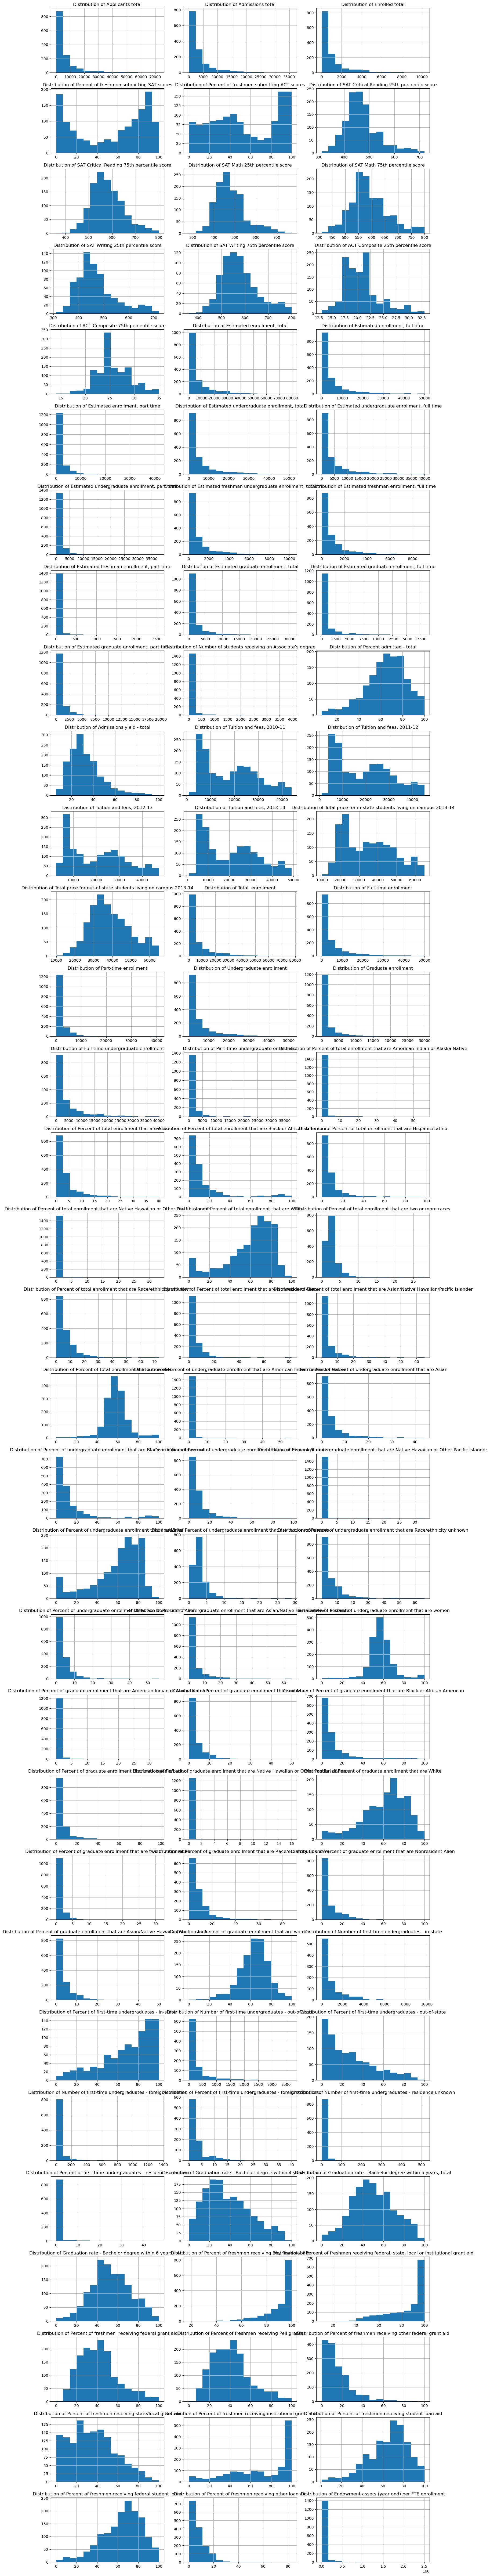

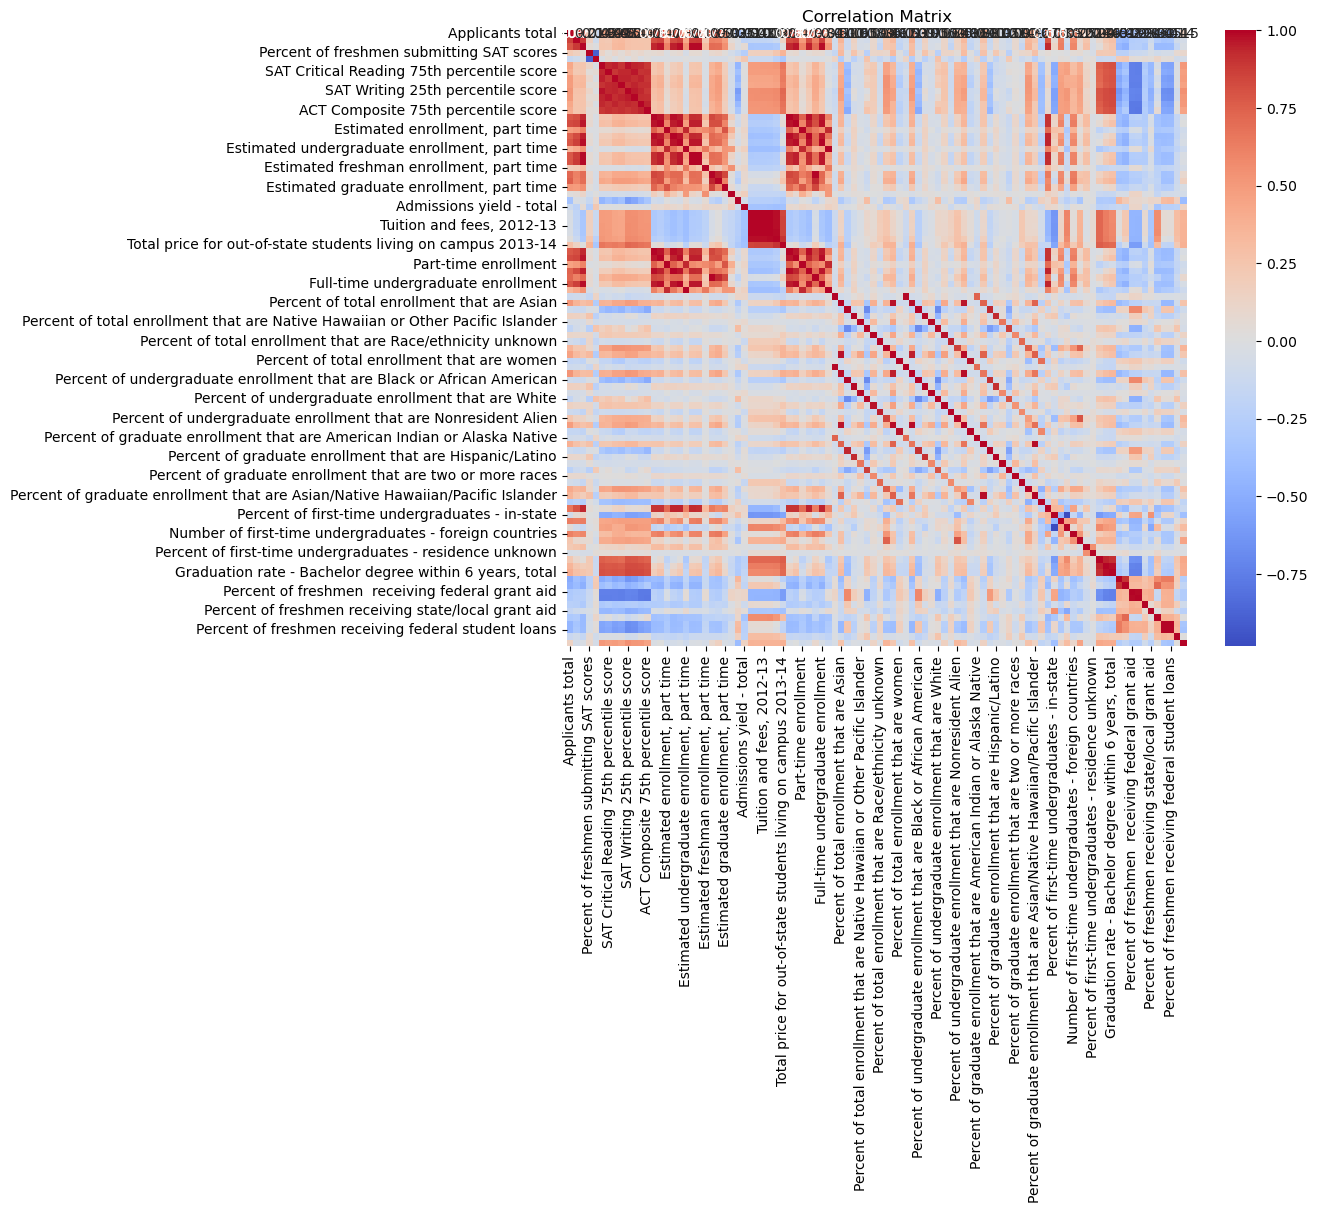

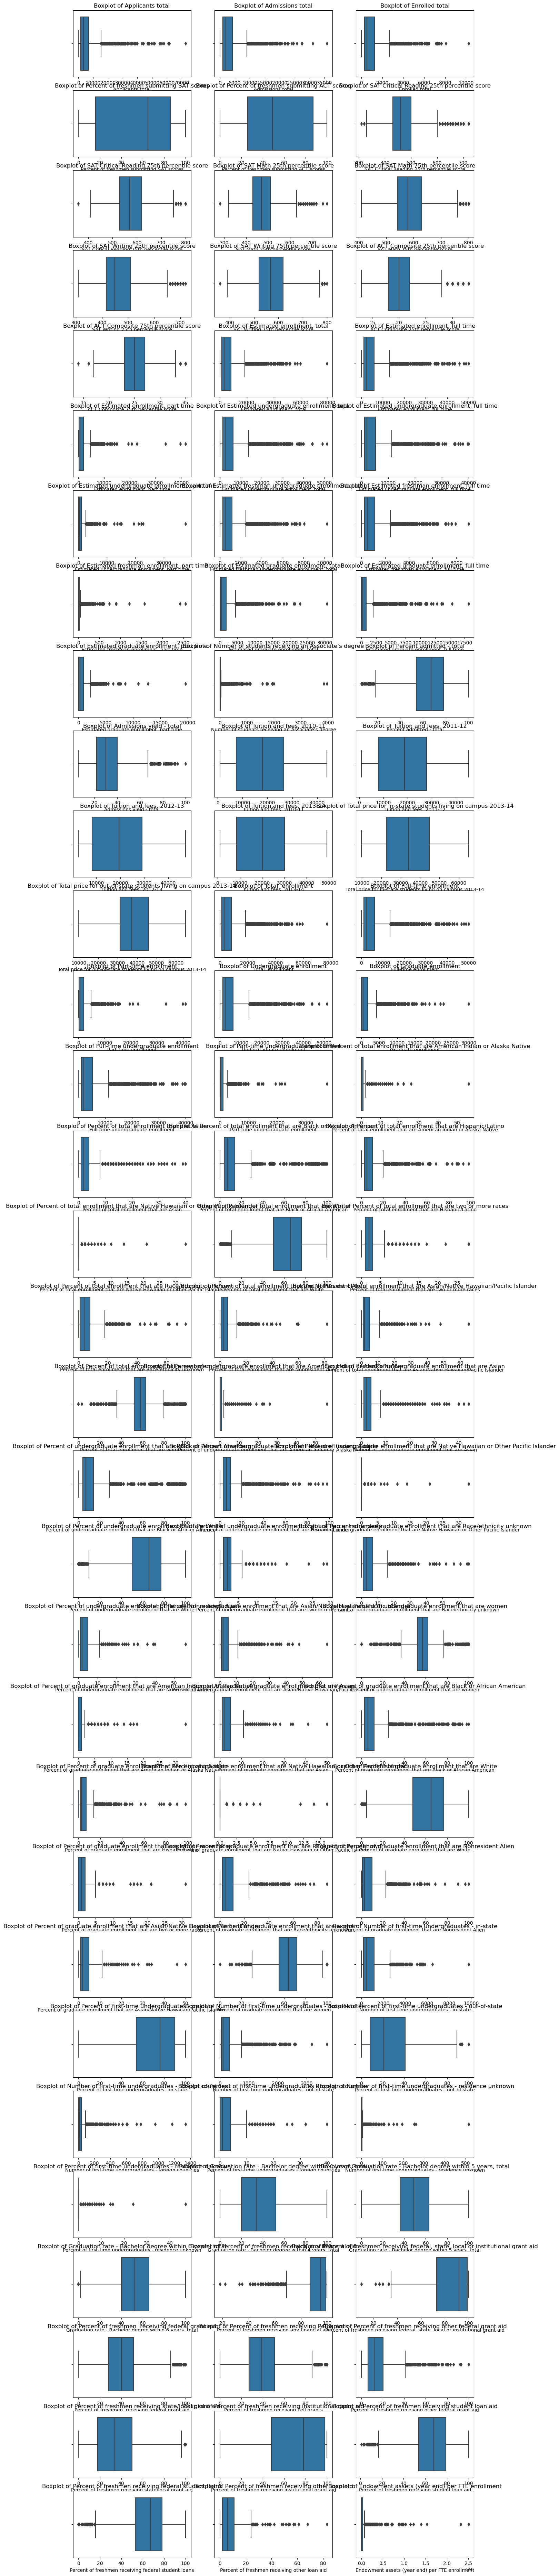

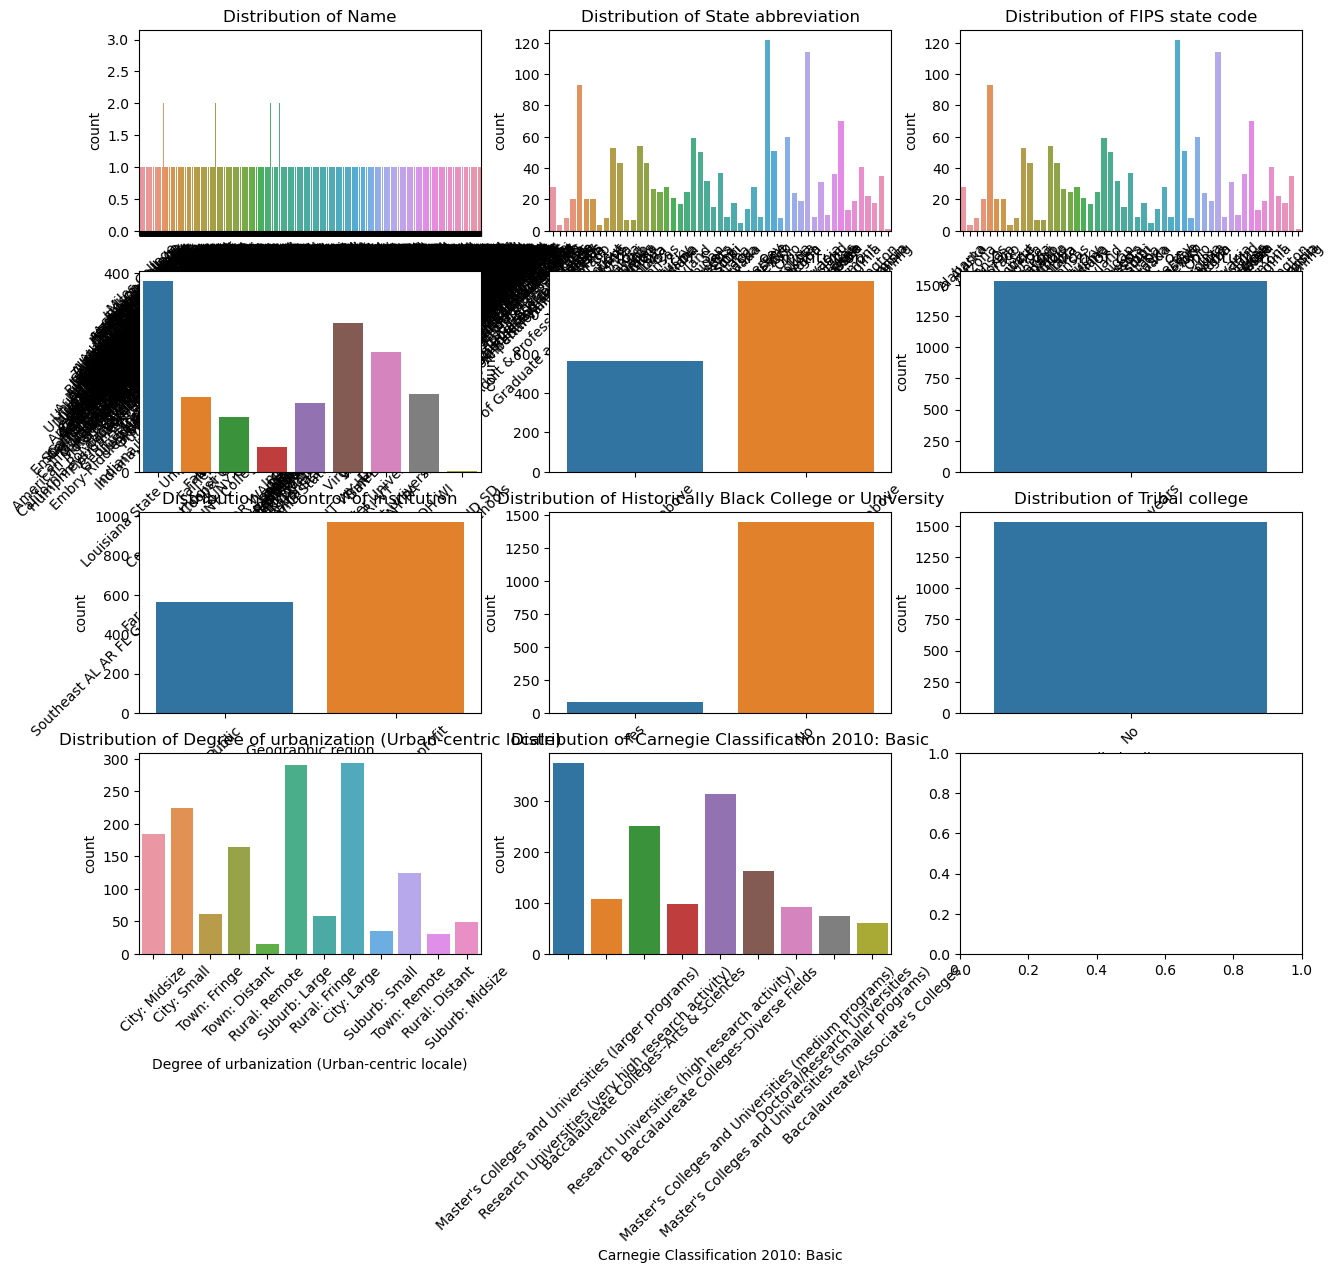

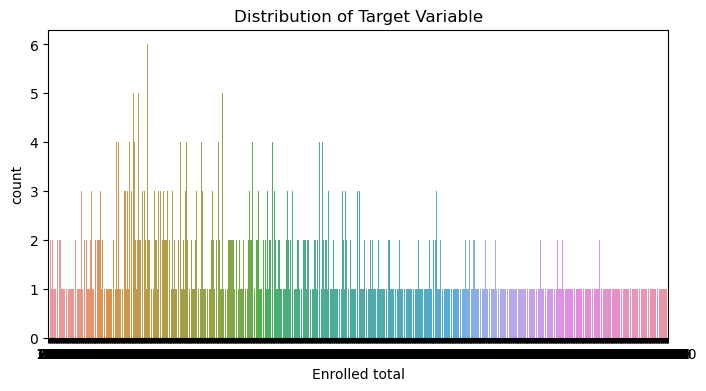

In [7]:
perform_eda(df)

In [8]:
# Calculate the percentage of missing values for each column
percent_missing = df.isnull().mean() * 100

# Lists to store column names
high_missing = []  # Columns with more than 30% missing values
moderate_missing = []  # Columns with 15-30% missing values
low_missing = []  # Columns with less than 15% missing values

# Categorize columns based on missing value percentage
for column, percent in percent_missing.items():
    if percent > 30:
        high_missing.append(column)
    elif 15 <= percent <= 30:
        moderate_missing.append(column)
    elif percent < 15:
        low_missing.append(column)

# Print the lists
print("Columns with >30% missing values:")
display(pd.DataFrame(high_missing))
print("Columns with 15-30% missing values:")
display(pd.DataFrame(moderate_missing))
print("Columns with <15% missing values:")
display(pd.DataFrame(low_missing))

Columns with >30% missing values:


0
0                  SAT Writing 25th percentile score
1                  SAT Writing 75th percentile score
2     Number of first-time undergraduates - in-state
3    Percent of first-time undergraduates - in-state
4  Number of first-time undergraduates - out-of-s...
5  Percent of first-time undergraduates - out-of-...
6  Number of first-time undergraduates - foreign ...
7  Percent of first-time undergraduates - foreign...
8  Number of first-time undergraduates - residenc...
9  Percent of first-time undergraduates - residen...

Columns with 15-30% missing values:


0
0           Percent of freshmen submitting SAT scores
1           Percent of freshmen submitting ACT scores
2          SAT Critical Reading 25th percentile score
3          SAT Critical Reading 75th percentile score
4                      SAT Math 25th percentile score
5                      SAT Math 75th percentile score
6                 ACT Composite 25th percentile score
7                 ACT Composite 75th percentile score
8   Percent of graduate enrollment that are Americ...
9       Percent of graduate enrollment that are Asian
10  Percent of graduate enrollment that are Black ...
11  Percent of graduate enrollment that are Hispan...
12  Percent of graduate enrollment that are Native...
13      Percent of graduate enrollment that are White
14  Percent of graduate enrollment that are two or...
15  Percent of graduate enrollment that are Race/e...
16  Percent of graduate enrollment that are Nonres...
17  Percent of graduate enrollment that are Asian/...
18      Percent of graduate enrollment that are women

Columns with <15% missing values:


0
0                                                Name
1                                    Applicants total
2                                    Admissions total
3                                      Enrolled total
4                         Estimated enrollment, total
5                     Estimated enrollment, full time
6                     Estimated enrollment, part time
7           Estimated undergraduate enrollment, total
8       Estimated undergraduate enrollment, full time
9       Estimated undergraduate enrollment, part time
10  Estimated freshman undergraduate enrollment, t...
11           Estimated freshman enrollment, full time
12           Estimated freshman enrollment, part time
13               Estimated graduate enrollment, total
14           Estimated graduate enrollment, full time
15           Estimated graduate enrollment, part time
16  Number of students receiving an Associate's de...
17                           Percent admitted - total
18                           Admissions yield - total
19                          Tuition and fees, 2010-11
20                          Tuition and fees, 2011-12
21                          Tuition and fees, 2012-13
22                          Tuition and fees, 2013-14
23  Total price for in-state students living on ca...
24  Total price for out-of-state students living o...
25                                 State abbreviation
26                                    FIPS state code
27                                  Geographic region
28                              Sector of institution
29                               Level of institution
30                             Control of institution
31           Historically Black College or University
32                                     Tribal college
33      Degree of urbanization (Urban-centric locale)
34                Carnegie Classification 2010: Basic
35                                  Total  enrollment
36                               Full-time enrollment
37                               Part-time enrollment
38                           Undergraduate enrollment
39                                Graduate enrollment
40                 Full-time undergraduate enrollment
41                 Part-time undergraduate enrollment
42  Percent of total enrollment that are American ...
43         Percent of total enrollment that are Asian
44  Percent of total enrollment that are Black or ...
45  Percent of total enrollment that are Hispanic/...
46  Percent of total enrollment that are Native Ha...
47         Percent of total enrollment that are White
48  Percent of total enrollment that are two or mo...
49  Percent of total enrollment that are Race/ethn...
50  Percent of total enrollment that are Nonreside...
51  Percent of total enrollment that are Asian/Nat...
52         Percent of total enrollment that are women
53  Percent of undergraduate enrollment that are A...
54  Percent of undergraduate enrollment that are A...
55  Percent of undergraduate enrollment that are B...
56  Percent of undergraduate enrollment that are H...
57  Percent of undergraduate enrollment that are N...
58  Percent of undergraduate enrollment that are W...
59  Percent of undergraduate enrollment that are t...
60  Percent of undergraduate enrollment that are R...
61  Percent of undergraduate enrollment that are N...
62  Percent of undergraduate enrollment that are A...
63  Percent of undergraduate enrollment that are w...
64  Graduation rate - Bachelor degree within 4 yea...
65  Graduation rate - Bachelor degree within 5 yea...
66  Graduation rate - Bachelor degree within 6 yea...
67    Percent of freshmen receiving any financial aid
68  Percent of freshmen receiving federal, state, ...
69   Percent of freshmen  receiving federal grant aid
70          Percent of freshmen receiving Pell grants
71  Percent of freshmen receiving other federal gr...
72  Percent of freshmen receiving state/local gran...
73  Percent of freshmen receiving institutional gr...
74

In [9]:
# Perform one-hot encoding for the necessary categorical features
encoded_df = pd.get_dummies(df, columns=['Geographic region'], prefix='gr_', drop_first=True)
encoded_df = pd.get_dummies(encoded_df, columns=['Control of institution'], prefix='ci_', drop_first=True)
encoded_df = pd.get_dummies(encoded_df, columns=['Historically Black College or University'], prefix='bc_', drop_first=True)
encoded_df = pd.get_dummies(encoded_df, columns=['Degree of urbanization (Urban-centric locale)'], prefix='urban_', drop_first=True)
encoded_df = pd.get_dummies(encoded_df, columns=['Carnegie Classification 2010: Basic'], prefix='carnegie_', drop_first=True)

df = encoded_df.copy()

In [10]:
# get percent of undergrads and grads
df['Percent of undergraduates'] = (df['Undergraduate enrollment'] * 100) / df['Total  enrollment']
df['Percent of graduates'] = (df['Graduate enrollment'] * 100) / df['Total  enrollment']

# fix percent admitted -total: Function to calculate percent admitted, skips NaN values
def calculate_percent_admitted(row):
    if pd.notna(row['Applicants total']) and pd.notna(row['Admissions total']):
        if row['Admissions total'] == 0:
            return round((row['Applicants total'] * 100) / (row['Admissions total'] + 1),0)
        elif row['Admissions total'] != 0:
            return round((row['Applicants total'] * 100) / row['Admissions total'],0)
    else:
        return np.nan

# Apply the function to each row
df['Percent admitted - total'] = df.apply(calculate_percent_admitted, axis=1)

# remove cols that either: A. Have too many missing values to accurately impute B. Potentially irrelevant to study
removal_cols = [
    'SAT Writing 25th percentile score',
    'SAT Writing 75th percentile score',
    'Percent of graduate enrollment that are American Indian or Alaska Native',
    'Percent of graduate enrollment that are Asian',
    'Percent of graduate enrollment that are Black or African American',
    'Percent of graduate enrollment that are Hispanic/Latino',
    'Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander',
    'Percent of graduate enrollment that are White',
    'Percent of graduate enrollment that are two or more races',
    'Percent of graduate enrollment that are Race/ethnicity unknown',
    'Percent of graduate enrollment that are Nonresident Alien',
    'Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander',
    'Percent of graduate enrollment that are women', 'Percent of first-time undergraduates - residence unknown',
    'Tribal college', 'FIPS state code', 'State abbreviation', 'Sector of institution', 'Level of institution', 'Percent of first-time undergraduates - in-state',
    'Percent of first-time undergraduates - out-of-state', 'Percent of first-time undergraduates - foreign countries',
    'Number of first-time undergraduates - foreign countries', 'Number of first-time undergraduates - residence unknown',
    'Number of first-time undergraduates - in-state', 'Number of first-time undergraduates - out-of-state',
    'Percent of undergraduate enrollment that are American Indian or Alaska Native', 'Percent of undergraduate enrollment that are Asian',
    'Percent of undergraduate enrollment that are Black or African American', 'Percent of undergraduate enrollment that are Hispanic/Latino',
    'Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander', 'Percent of undergraduate enrollment that are White',
    'Percent of undergraduate enrollment that are two or more races', 'Percent of undergraduate enrollment that are Race/ethnicity unknown',
    'Percent of undergraduate enrollment that are Nonresident Alien', 'Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander',
    'Percent of undergraduate enrollment that are women']

df = df.drop(columns=removal_cols)
impute_cols = ['Applicants total', 'Admissions total',
     'Percent of freshmen submitting SAT scores',
     'Percent of freshmen submitting ACT scores',
     "Number of students receiving an Associate's degree",
     'Percent admitted - total',
     'Admissions yield - total',
     'Tuition and fees, 2010-11',
     'Tuition and fees, 2011-12',
     'Tuition and fees, 2012-13',
     'Tuition and fees, 2013-14',
     'Total price for in-state students living on campus 2013-14',
     'Total price for out-of-state students living on campus 2013-14',
     'Total  enrollment',
     'Full-time enrollment',
     'Part-time enrollment',
     'Undergraduate enrollment',
     'Graduate enrollment',
     'Full-time undergraduate enrollment',
     'Part-time undergraduate enrollment',
     'Percent of total enrollment that are American Indian or Alaska Native',
     'Percent of total enrollment that are Asian',
     'Percent of total enrollment that are Black or African American',
     'Percent of total enrollment that are Hispanic/Latino',
     'Percent of total enrollment that are Native Hawaiian or Other Pacific Islander',
     'Percent of total enrollment that are White',
     'Percent of total enrollment that are two or more races',
     'Percent of total enrollment that are Race/ethnicity unknown',
     'Percent of total enrollment that are Nonresident Alien',
     'Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander',
     'Percent of total enrollment that are women',
     'Graduation rate - Bachelor degree within 4 years, total',
     'Graduation rate - Bachelor degree within 5 years, total',
     'Graduation rate - Bachelor degree within 6 years, total',
     'Percent of freshmen receiving any financial aid',
     'Percent of freshmen receiving federal, state, local or institutional grant aid',
     'Percent of freshmen  receiving federal grant aid',
     'Percent of freshmen receiving Pell grants',
     'Percent of freshmen receiving other federal grant aid',
     'Percent of freshmen receiving state/local grant aid',
     'Percent of freshmen receiving institutional grant aid',
     'Percent of freshmen receiving student loan aid',
     'Percent of freshmen receiving federal student loans',
     'Percent of freshmen receiving other loan aid',
     'Endowment assets (year end) per FTE enrollment']
targets = ['Enrolled total',
    'Admissions yield - total',
    'Estimated enrollment, total',
    'Estimated enrollment, full time',
    'Estimated enrollment, part time',
    'Estimated undergraduate enrollment, total',
    'Estimated undergraduate enrollment, full time',
    'Estimated undergraduate enrollment, part time',
    'Estimated freshman undergraduate enrollment, total',
    'Estimated freshman enrollment, full time',
    'Estimated freshman enrollment, part time',
    'Estimated graduate enrollment, total',
    'Estimated graduate enrollment, full time',
    'Estimated graduate enrollment, part time'
]

In [11]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 96 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Name                                                                            1534 non-null   object 
 1   Applicants total                                                                1377 non-null   float64
 2   Admissions total                                                                1377 non-null   float64
 3   Enrolled total                                                                  1377 non-null   float64
 4   Percent of freshmen submitting SAT scores                                       1257 non-null   float64
 5   Percent of freshmen submitting ACT scores                                       1259 non-null   float64
 6   SAT Critical Rea

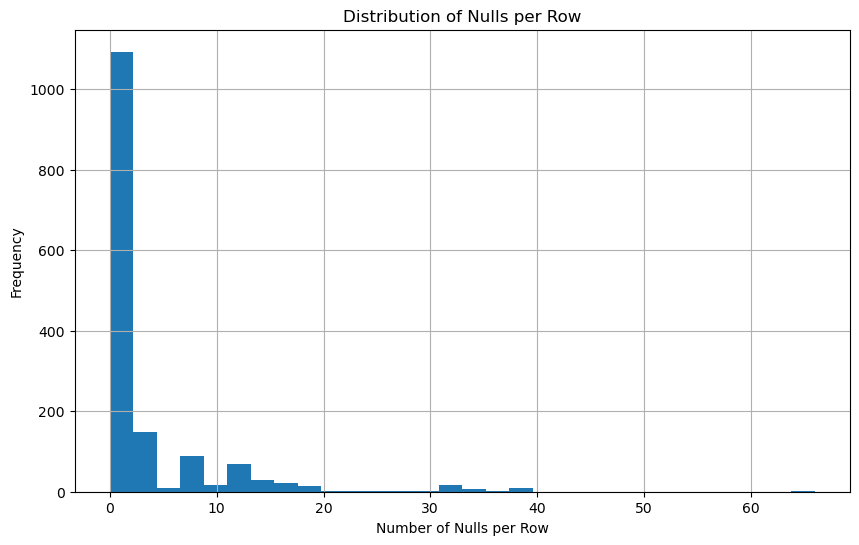

In [12]:
# Count the number of nulls in each row
null_counts_per_row = df.isnull().sum(axis=1)

# Plotting the distribution of null counts per row
plt.figure(figsize=(10, 6))
null_counts_per_row.hist(bins=30)
plt.xlabel('Number of Nulls per Row')
plt.ylabel('Frequency')
plt.title('Distribution of Nulls per Row')
plt.show()

In [13]:
perform_eda(df, types='missing')

In [14]:
# Attempt XGBoosted imputations
def objective(trial, X, y):
    # Define the hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
    }

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(**param, random_state=42)
    
    # Fit the model with early stopping
    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50,
              verbose=False) # Set verbose to False to reduce output

    # Predict on validation set
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

def imputation_analysis(df, column_to_impute):
    # Filter rows where the target column is not missing
    subset = df[df[column_to_impute].notna()]

    # Separate features and target
    X = subset.drop(columns=[column_to_impute])
    y = subset[column_to_impute]

    # Set logging level to WARNING to suppress detailed trial output
    logging.getLogger('optuna').setLevel(logging.WARNING)

    # Optuna for hyperparameter tuning
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

    # Best hyperparameters
    best_params = study.best_params

    # Train the model using the best hyperparameters
    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X, y)

    # KFold cross-validation for evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Calculate average metrics
    mse_avg = -mse_scores.mean()
    mae_avg = -mae_scores.mean()
    r2_avg = r2_scores.mean()

    return mse_avg, mae_avg, r2_avg, best_params



df_impute_test = df[df.select_dtypes(include=['float64', 'int64', 'bool']).columns].copy()
df_impute_test = df_impute_test.drop(columns=targets)

# Analyze columns and store results
column_analysis = {}
imputed_values = {}  # To store imputed values for each column

# Run modeling of XGBoost imputation for missing values
for ele in impute_cols:
    if ele in df_impute_test.columns:
        print(f'{ele} modeling...')
        mse, mae, r2, best_params = imputation_analysis(df_impute_test, ele)
        column_analysis[ele] = {'mse': mse, 'mae': mae, 'r2': r2}

        # Impute missing values only if the model performs well (e.g., r2 > 0.7)
        if r2 > 0.75:
            model = XGBRegressor(**best_params, random_state=42)
            train_subset = df_impute_test[df_impute_test[ele].notna()]
            model.fit(train_subset.drop(columns=[ele]), train_subset[ele])
            # Predict for all rows where the value is missing
            imputed_values[ele] = model.predict(df_impute_test[df_impute_test[ele].isna()].drop(columns=[ele]))
    else:
        print(f"Column {ele} not found in DataFrame.")
# Display the analysis result
cols = pd.DataFrame(column_analysis)
cols = cols.T
display(cols[cols['r2']>0.7].sort_values(by='r2', ascending=False))

Applicants total modeling...
Admissions total modeling...
Percent of freshmen submitting SAT scores modeling...
Percent of freshmen submitting ACT scores modeling...
Number of students receiving an Associate's degree modeling...
Percent admitted - total modeling...
Column Admissions yield - total not found in DataFrame.
Tuition and fees, 2010-11 modeling...
Tuition and fees, 2011-12 modeling...
Tuition and fees, 2012-13 modeling...
Tuition and fees, 2013-14 modeling...
Total price for in-state students living on campus 2013-14 modeling...
Total price for out-of-state students living on campus 2013-14 modeling...
Total  enrollment modeling...
Full-time enrollment modeling...
Part-time enrollment modeling...
Undergraduate enrollment modeling...
Graduate enrollment modeling...
Full-time undergraduate enrollment modeling...
Part-time undergraduate enrollment modeling...
Percent of total enrollment that are American Indian or Alaska Native modeling...
Percent of total enrollment that are As

mse      mae    r2
Tuition and fees, 2012-13                           2.22e+05   245.19  1.00
Tuition and fees, 2011-12                           2.94e+05   229.52  1.00
Tuition and fees, 2010-11                           4.16e+05   364.20  1.00
Tuition and fees, 2013-14                           7.29e+05   365.74  1.00
Total price for in-state students living on cam...  1.25e+06   609.71  0.99
Percent of freshmen receiving federal student l...  2.71e+00     0.97  0.99
Percent of freshmen receiving student loan aid      2.66e+00     0.91  0.99
Total  enrollment                                   7.10e+05   218.50  0.99
Full-time undergraduate enrollment                  3.16e+05   206.20  0.99
Undergraduate enrollment                            4.84e+05   214.01  0.99
Full-time enrollment                                7.11e+05   314.80  0.99
Percent of freshmen receiving Pell grants           5.79e+00     1.17  0.98
Percent of total enrollment that are Asian/Nati...  5.81e-01     0.30  0.98
Percent of freshmen  receiving federal grant aid    6.24e+00     1.17  0.98
Graduation rate - Bachelor degree within 5 year...  9.06e+00     1.54  0.98
Percent of total enrollment that are Asian          6.43e-01     0.36  0.97
Percent of total enrollment that are White          1.38e+01     2.23  0.97
Graduation rate - Bachelor degree within 6 year...  1.23e+01     1.89  0.97
Admissions total                                    6.97e+05   289.41  0.97
Total price for out-of-state students living on...  4.22e+06  1182.79  0.96
Applicants total                                    3.33e+06   627.80  0.96
Percent of freshmen receiving federal, state, l...  1.37e+01     2.11  0.95
Graduate enrollment                                 4.05e+05   197.66  0.95
Percent of total enrollment that are Black or A...  1.83e+01     2.60  0.95
Graduation rate - Bachelor degree within 4 year...  2.94e+01     3.62  0.94
Part-time undergraduate enrollment                  3.65e+05   186.82  0.93
Part-time enrollment                                7.27e+05   286.32  0.92
Percent of freshmen receiving any financial aid     1.15e+01     1.86  0.92
Percent of freshmen submitting ACT scores           1.09e+02     7.43  0.89
Percent of freshmen submitting SAT scores           1.30e+02     8.26  0.89
Percent of freshmen receiving institutional gra...  1.45e+02     7.40  0.83
Percent admitted - total                            2.90e+03    22.80  0.83
Percent of total enrollment that are Hispanic/L...  2.01e+01     2.53  0.81
Percent of total enrollment that are Race/ethni...  1.39e+01     2.37  0.73

In [15]:
# Merge the imputed values back into the original DataFrame
for col, values in imputed_values.items():
    df_impute_test.loc[df_impute_test[col].isna(), col] = values

In [16]:
perform_eda(df_impute_test, types='missing')

In [17]:
columns_for_median_imputation = df_impute_test.columns[df_impute_test.isna().any()].tolist()
df_clean = df_impute_test.copy()
# Perform median imputation
for col in columns_for_median_imputation:
    median_value = df_clean[col].median()
    df_clean[col].fillna(median_value, inplace=True)

In [18]:
df_clean = pd.concat([df_clean,df[df.select_dtypes(include=['object']).columns]], axis=1)
print(df_clean.shape)
display(df_clean.head())

(1534, 82)


Applicants total  Admissions total  \
0           6142.00           5521.00   
1           5689.00           4934.00   
2          39302.04           7143.39   
3           2054.00           1656.00   
4          10245.00           5251.00   

   Percent of freshmen submitting SAT scores  \
0                                      15.00   
1                                       6.00   
2                                      32.67   
3                                      34.00   
4                                      18.00   

   Percent of freshmen submitting ACT scores  \
0                                      88.00   
1                                      93.00   
2                                      68.83   
3                                      94.00   
4                                      87.00   

   SAT Critical Reading 25th percentile score  \
0                                       370.0   
1                                       520.0   
2                                       460.0   
3                                       510.0   
4                                       380.0   

   SAT Critical Reading 75th percentile score  SAT Math 25th percentile score  \
0                                       450.0                           350.0   
1                                       640.0                           520.0   
2                                       570.0                           470.0   
3                                       640.0                           510.0   
4                                       480.0                           370.0   

   SAT Math 75th percentile score  ACT Composite 25th percentile score  \
0                           450.0                                 15.0   
1                           650.0                                 22.0   
2                           580.0                                 20.0   
3                           650.0                                 23.0   
4                           480.0                                 15.0   

   ACT Composite 75th percentile score  \
0                                 19.0   
1                                 28.0   
2                                 25.0   
3                                 29.0   
4                                 19.0   

   Number of students receiving an Associate's degree  \
0                                                0.0    
1                                                0.0    
2                                                5.0    
3                                                0.0    
4                                                0.0    

   Percent admitted - total  Tuition and fees, 2010-11  \
0                    111.00                     5800.0   
1                    115.00                     5806.0   
2                    270.99                     8360.0   
3                    124.00                     7492.0   
4                    195.00                     7164.0   

   Tuition and fees, 2011-12  Tuition and fees, 2012-13  \
0                     6828.0                     7182.0   
1                     6264.0                     6798.0   
2                     8720.0                     6800.0   
3                     8094.0                     8794.0   
4                     8082.0                     7932.0   

   Tuition and fees, 2013-14  \
0                     7182.0   
1                     7206.0   
2                     6870.0   
3                     9192.0   
4                     8720.0   

   Total price for in-state students living on campus 2013-14  \
0                                           21849.00            
1                                           22495.00            
2                                           26798.98            
3                                           23466.00            
4                                           18286.00            

   Total price for out-of-state students living on campus 2013-14  

In [21]:
df_clean['Percent Full-time enrollment'] = df_clean['Full-time enrollment'] / df_clean['Total  enrollment']
df_clean['Percent Part-time enrollment'] = df_clean['Part-time enrollment'] / df_clean['Total  enrollment']
df_clean['Percent Undergraduate enrollment'] = df_clean['Undergraduate enrollment'] / df_clean['Total  enrollment']
df_clean['Percent Graduate enrollment'] = df_clean['Graduate enrollment'] / df_clean['Total  enrollment']
df_clean['Percent full-time undergraduate enrollment'] = df_clean['Full-time undergraduate enrollment'] / df_clean['Total  enrollment']
df_clean['Percent part-time undergraduate enrollment'] = df_clean['Part-time undergraduate enrollment'] / df_clean['Total  enrollment']

columns_to_drop = [
    'Full-time enrollment', 
    'Part-time enrollment', 
    'Undergraduate enrollment', 
    'Graduate enrollment',
    'Full-time undergraduate enrollment',
    'Part-time undergraduate enrollment'
]

df_clean = df_clean.drop(columns=columns_to_drop)


In [22]:
combination = df_clean.copy()
combination = pd.concat([combination,df[targets]], axis=1)
combination = combination[combination['Enrolled total'].isna()==False]

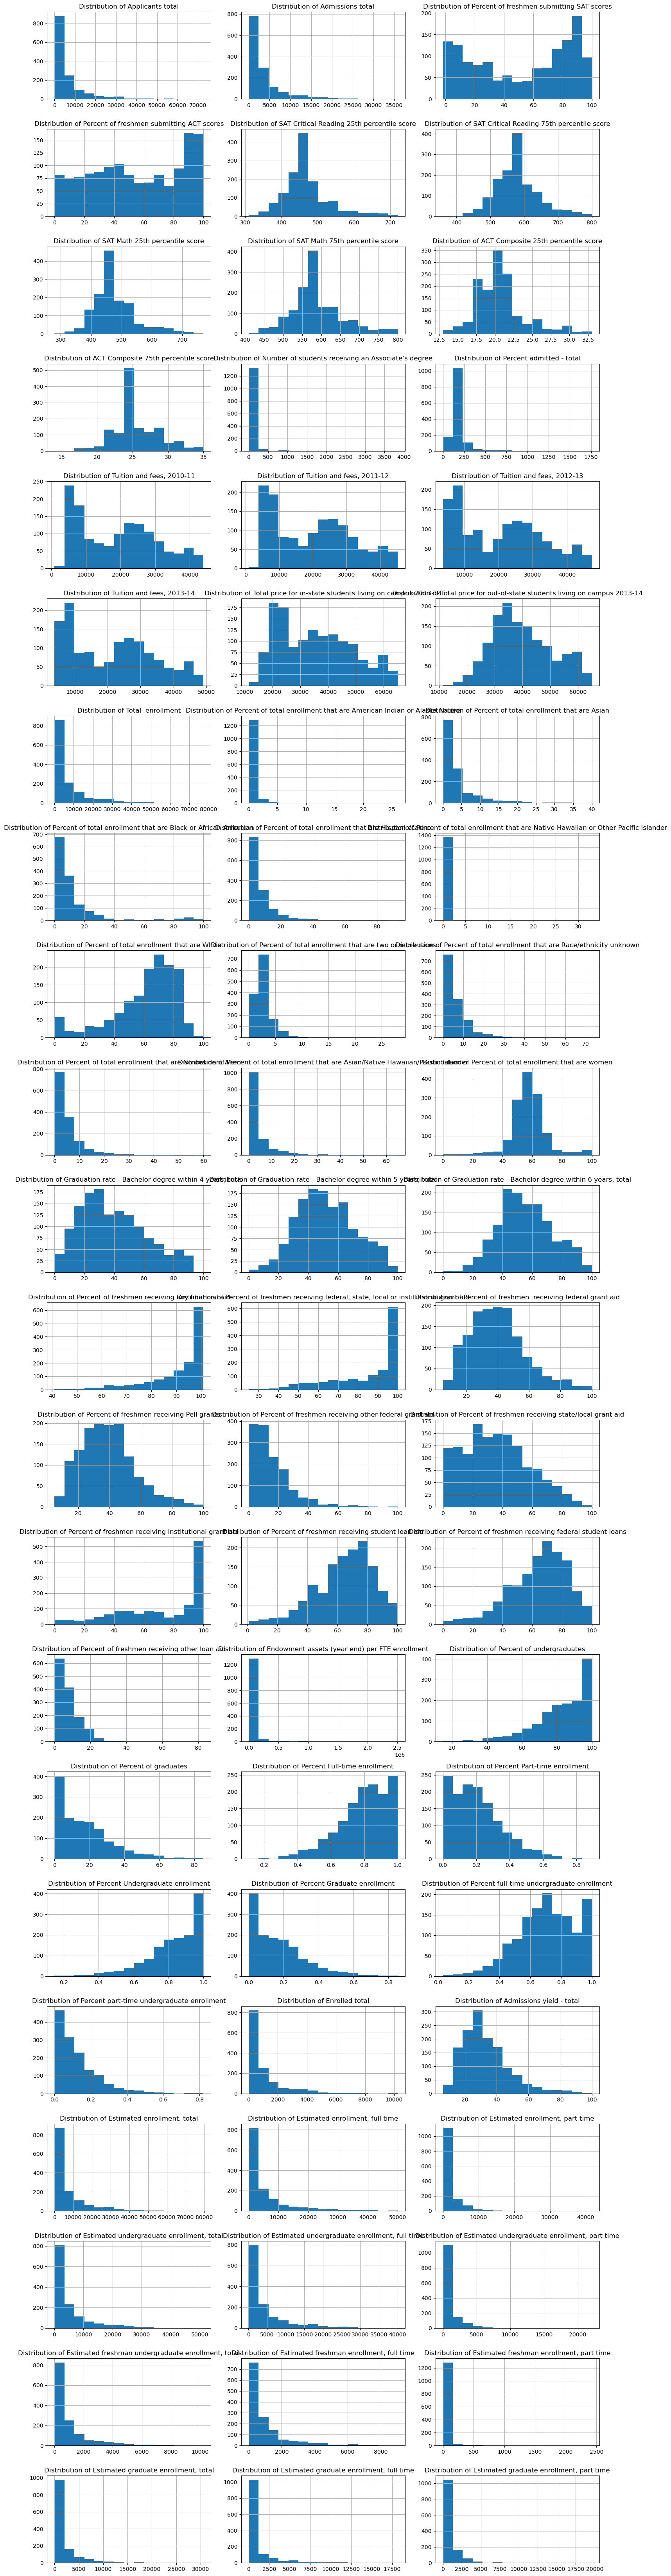

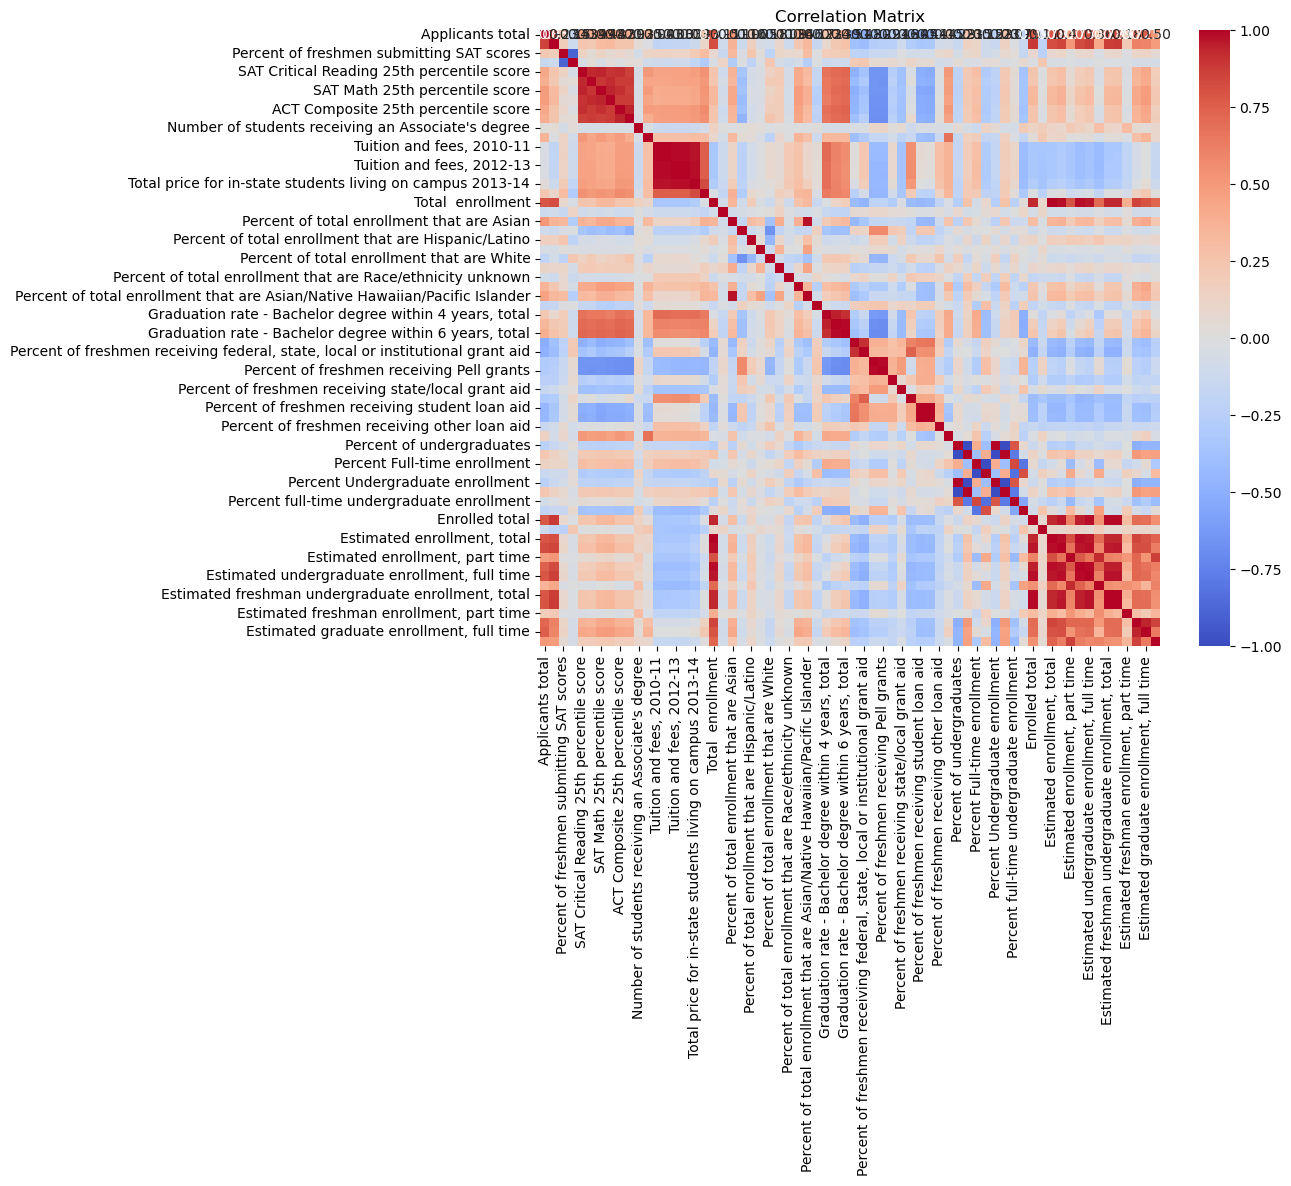

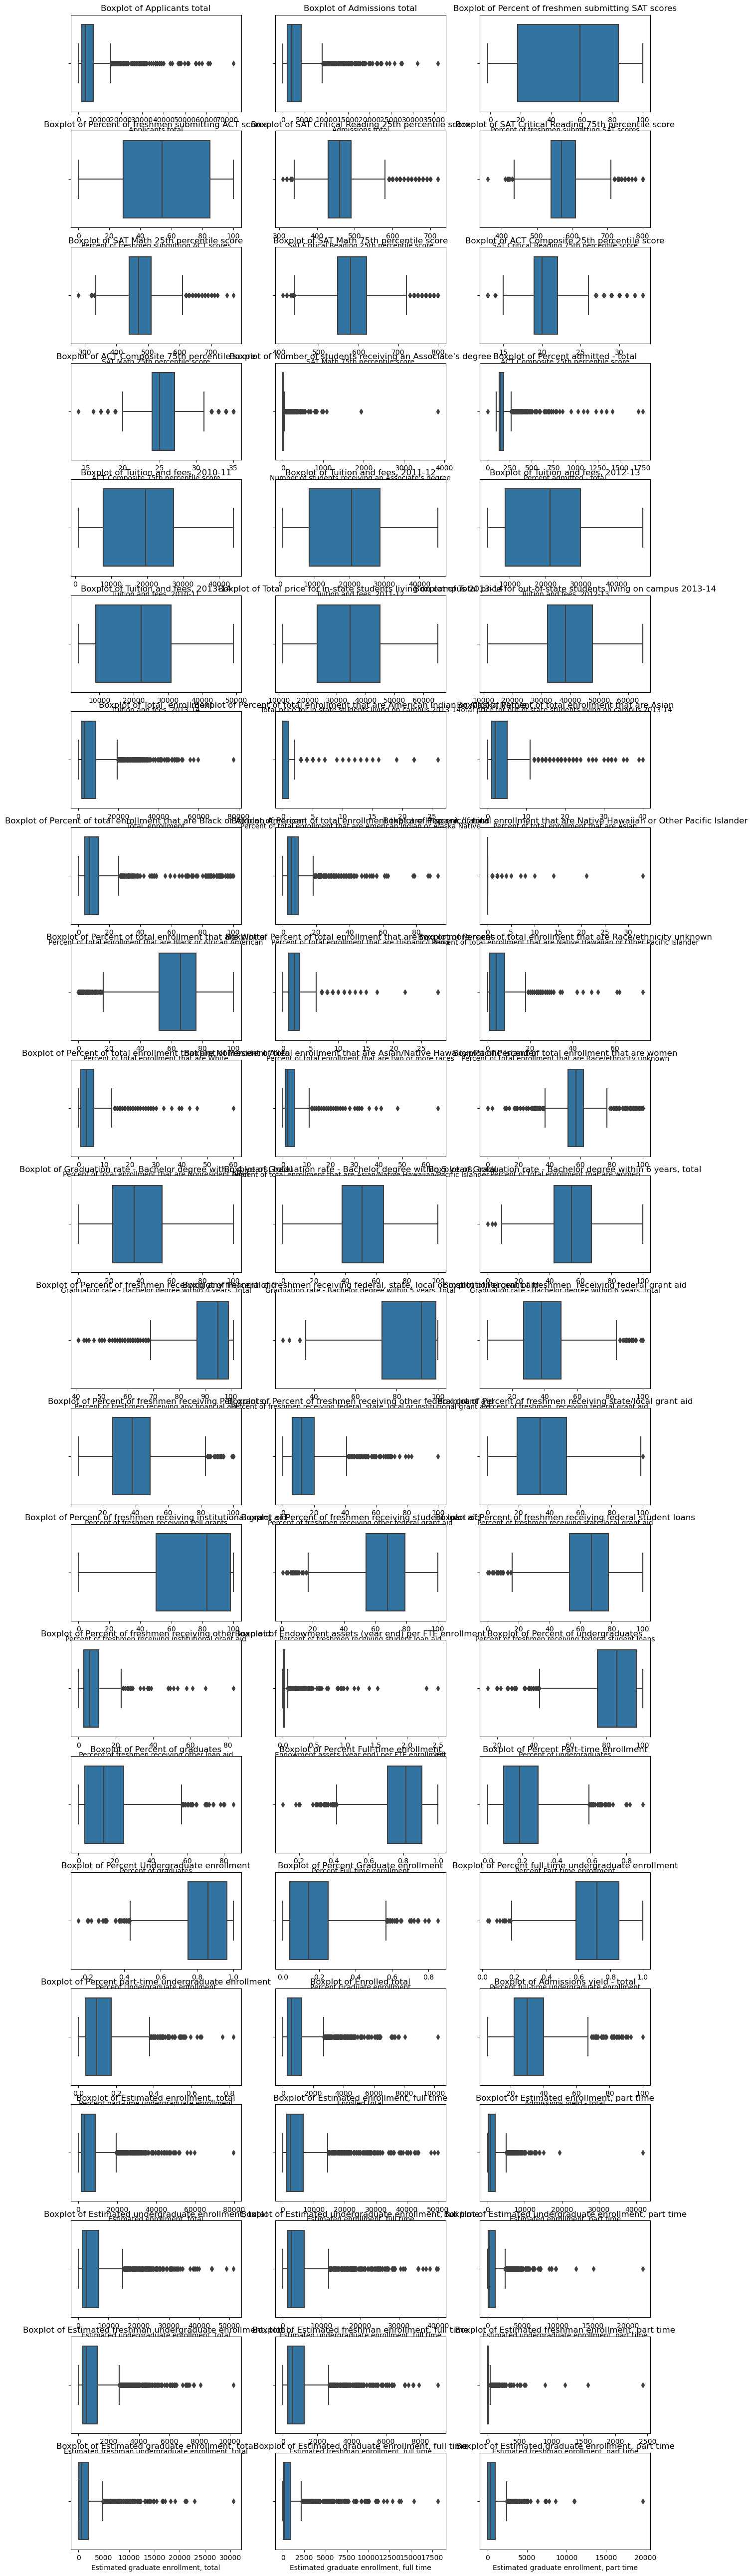

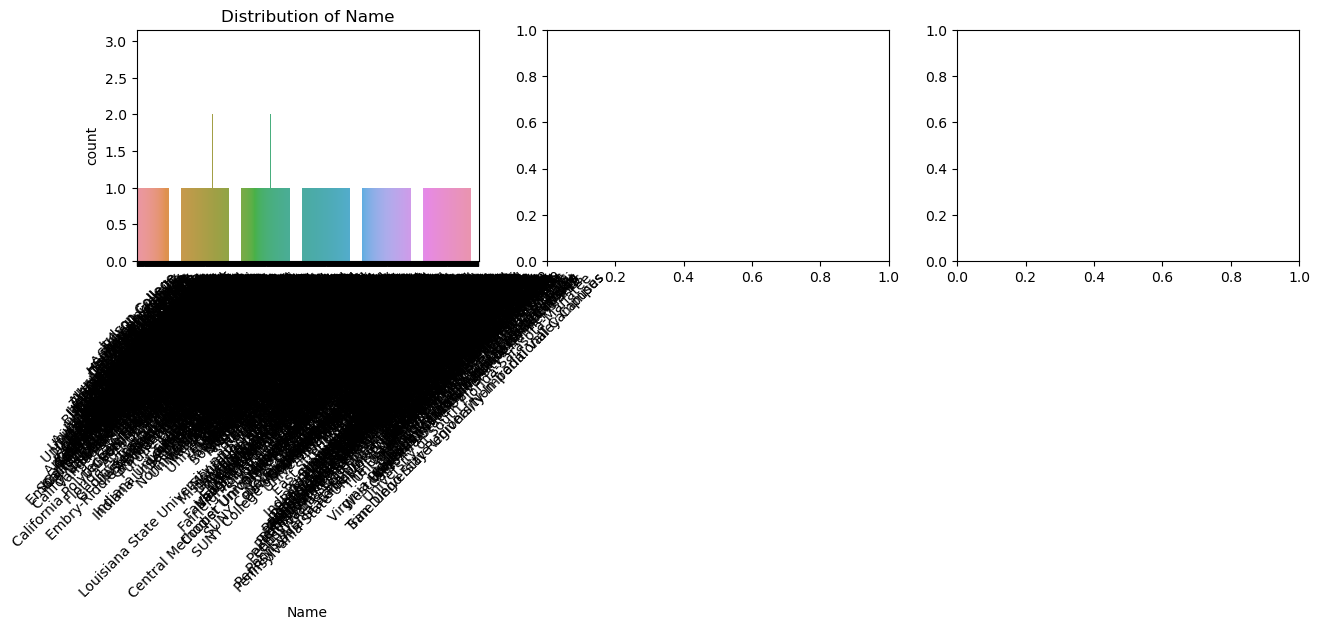

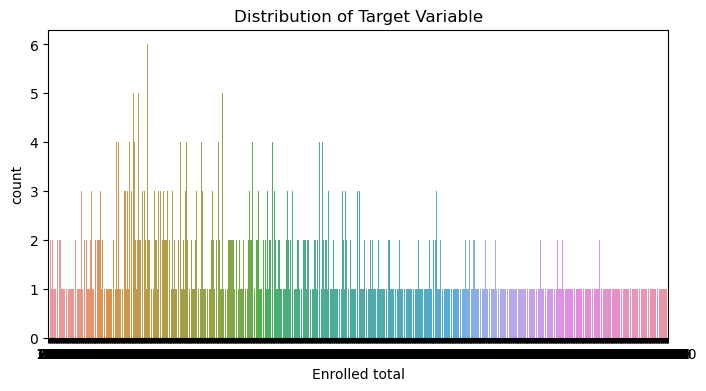

In [23]:
perform_eda(combination, types='all')

In [24]:
from sklearn.preprocessing import StandardScaler

def prepare_data(df):
    """
    Prepare data for different models including FNN, with necessary normalizations.

    Parameters:
    df (DataFrame): The dataset to be prepared.
    target_column (str): The target column name.

    Returns:
    dict: A dictionary containing datasets prepared for different models.
    """

    prepared_datasets = {}

    # Excluding non-numeric columns for normalization
    df_numeric = df.select_dtypes(include=[np.number])
    df_non_numeric = df.select_dtypes(exclude=[np.number])

    # Normalization for Linear Regression and FNN
    scaler = StandardScaler()
    df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

    # Resetting index to align the dataframes correctly
    df_numeric_scaled.reset_index(drop=True, inplace=True)
    df_non_numeric.reset_index(drop=True, inplace=True)

    # Reassembling the dataset with both numeric and non-numeric columns
    df_scaled = pd.concat([df_numeric_scaled, df_non_numeric], axis=1)

    # Preparing data for Linear Regression and FNN (normalized)
    prepared_datasets['Linear Regression'] = df_scaled
    prepared_datasets['Feedforward Neural Network'] = df_scaled

    # Data for tree-based models (no normalization required)
    prepared_datasets['Trees'] = df.copy()

    return prepared_datasets


In [25]:
df_clean = combination.drop(columns=targets, axis=1)

## Models

In [45]:
from sklearn.linear_model import Ridge, Lasso
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, learning_curve

def regression_optuna_tuning(subset_split_data, n_trials=0, timeout=10800, random_state=42):
    """
    Conducts hyperparameter optimization for Ridge or Lasso regression models using Optuna.
    
    Parameters:
    - subset_split_data (dict): A dictionary containing 'X_train', 'X_val', 'y_train', 'y_val'.
    - n_trials (int, optional): The number of optimization trials. Default is 0.
    - timeout (int, optional): The time limit for the optimization in seconds. Default is 10800 (3 hours).
    - random_state (int, optional): Seed for random number generation to ensure reproducibility. Default is 42.

    Returns:
    - dict: A dictionary containing the best model, its hyperparameters, MSE, MAE, R2 scores, and the Optuna study object.
    
    The function performs data validation checks, conducts hyperparameter tuning using Optuna, and evaluates the best model 
    on the validation set. It also plots actual vs. predicted values and a learning curve, and visualizes the importance of the 
    top 15 features. The results include the best model type, its parameters, and performance metrics.
    """

    X_train = subset_split_data['X_train']
    y_train = subset_split_data['y_train']
    X_val = subset_split_data['X_val']
    y_val = subset_split_data['y_val']

    if X_train.shape[0] != y_train.shape[0] or X_val.shape[0] != y_val.shape[0]:
        raise ValueError("Inconsistent data shapes between features and labels.")

    def objective(trial):
        model_type = trial.suggest_categorical("model_type", ["Lasso", "Ridge"])
        alpha = trial.suggest_float('alpha', 1e-3, 10, log=True)
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)

        if model_type == 'Ridge':
            model = Ridge(alpha=alpha, fit_intercept=fit_intercept, tol=tol, random_state=random_state)
        elif model_type == 'Lasso':
            model = Lasso(alpha=alpha, fit_intercept=fit_intercept, tol=tol, random_state=random_state)

        mse = -cross_val_score(model, X_train, y_train, n_jobs=-1, cv=KFold(10), scoring='neg_mean_squared_error').mean()
        return mse

    storage_url = "sqlite:///college_reg_study.db"
    study = optuna.create_study(direction='minimize', study_name="college_reg_study", storage=storage_url, load_if_exists=True, sampler=optuna.samplers.TPESampler(seed=random_state))
    print(f"Number of trials in the study: {len(study.trials)}")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    best_params = study.best_params
    best_model_type = best_params.pop("model_type")
    if best_model_type == "Ridge":
        best_model = Ridge(**best_params, random_state=random_state)
        best_model.fit(X_train, y_train)
        coefficients = best_model.coef_
        features = X_train.columns
        coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    else:
        best_model = Lasso(**best_params, random_state=random_state)
        best_model.fit(X_train, y_train)
        coefficients = best_model.coef_
        features = X_train.columns
        coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

    # Calculate evaluation metrics
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Calculate learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=KFold(10), n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error'
    )

    # Convert scores to positive values (since they are negative MSE)
    train_scores = -train_scores.mean(axis=1)
    val_scores = -val_scores.mean(axis=1)

    # Actual vs. Predicted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10), scoring='neg_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

    # Calculate the absolute value of coefficients
    coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()

    # Sort the dataframe by the absolute value of coefficients
    sorted_coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

    # Select the top 15 features
    top_features = sorted_coeff_df.head(15)

    # Plotting the feature importance of top 15 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features)
    plt.title(f'{best_model_type} Regression Top 15 Feature Importance')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.show()
    
    # Output results
    results = {
        'best_model_type': best_model_type,
        'best_hyperparameters': best_params,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'trained_model': best_model,
        'optuna_study': study
    }

    return results

In [46]:
def randomforest_optuna_tuning(subset_split_data, n_trials=0, timeout=10800, random_state=42):
    """
    Optimizes hyperparameters of a RandomForest model using Optuna with Hyperband pruning.

    Parameters:
        subset_split_data (dict): Dictionary containing 'X_train', 'X_val', 'y_train', 'y_val' datasets.
        n_trials (int, optional): The number of trials for Optuna optimization. Default is 0.
        timeout (int, optional): Time limit for the study in seconds. Default is 10800 (3 hours).
        random_state (int, optional): Seed for random number generation to ensure reproducibility. Default is 42.

    Returns:
        dict: Dictionary with best hyperparameters, MSE, MAE, R2 scores, best model, and Optuna study.

    The function validates input data, conducts hyperparameter tuning using Optuna, evaluates the best RandomForest model,
    and plots actual vs. predicted values and learning curves. It returns the best model parameters, performance metrics, and 
    an Optuna study object for further analysis.
    """

    # Extract dataset from input dictionary, validating the expected structure
    try:
        X_train = subset_split_data['X_train']
        y_train = subset_split_data['y_train']
        X_val = subset_split_data['X_val']
        y_val = subset_split_data['y_val']

    except KeyError as e:
        raise ValueError(f"Missing key in subset_split_data: {str(e)}")

    if X_train.shape[0] != y_train.shape[0] or X_val.shape[0] != y_val.shape[0]:
        raise ValueError("Inconsistent data shapes between features and labels.")

    def objective(trial):
        # Define hyperparameter search space
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 14)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 8)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        
        # Initialize the RandomForest model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state
        )

        # Cross-validation scoring using MSE
        n_splits = 10
        mse = -cross_val_score(model, X_train, y_train, n_jobs=-1, cv=KFold(n_splits), scoring='neg_mean_squared_error').mean()
        return mse

    # Set up the Optuna study with HyperbandPruner
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=n_trials, reduction_factor=3)
    study = optuna.create_study(direction='minimize', study_name="randomforest_study", pruner=pruner,
                                storage=f"sqlite:///randomforest_study.db", load_if_exists=True,
                                sampler=optuna.samplers.TPESampler(seed=random_state))
    print(f"Number of trials in the study: {len(study.trials)}")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Fetch the best hyperparameters
    best_params = study.best_params
    best_score = study.best_value

    # Train RandomForest with the best parameters
    best_model = RandomForestRegressor(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)

    # Calculate evaluation metrics
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Extract feature importances
    importances = best_model.feature_importances_
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    # Select the top 15 features
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    top_features = importance_df.head(15)
    
    # Calculate learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=KFold(10), n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error'
    )

    # Convert scores to positive values (since they are negative MSE)
    train_scores = -train_scores.mean(axis=1)
    val_scores = -val_scores.mean(axis=1)

    # Actual vs. Predicted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=10, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10), scoring='neg_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

    # Plotting the feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()    
    
    # Output results
    results = {
        'best_hyperparameters': best_params,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'trained_model': best_model,
        'optuna_study': study
    }

    return results

In [47]:
def xgboost_optuna_tuning(subset_split_data, n_trials=0, timeout=10800, random_state=42):
    """
    Conducts hyperparameter optimization for an XGBoost model using Optuna with Hyperband pruning.

    Parameters:
        subset_split_data (dict): Dictionary containing 'X_train', 'X_val', 'y_train', 'y_val'.
        n_trials (int, optional): The number of trials for Optuna optimization. Default is 0.
        timeout (int, optional): Time limit for the optimization in seconds. Default is 10800 (3 hours).
        random_state (int, optional): Seed for random number generation to ensure reproducibility. Default is 42.

    Returns:
        dict: A dictionary containing the best model, its hyperparameters, MSE, MAE, R2 scores, and the Optuna study object.
    
    The function performs data validation checks, conducts hyperparameter tuning using Optuna, evaluates the best XGBoost model 
    on the validation set, and plots actual vs. predicted values, learning curves, and feature importance. It returns the best 
    model parameters and performance metrics, along with the Optuna study object for further analysis.
    """

    # Extract dataset from input dictionary, validating the expected structure
    X_train = subset_split_data['X_train']
    y_train = subset_split_data['y_train']
    X_val = subset_split_data['X_val']
    y_val = subset_split_data['y_val']

    def objective(trial):
        # Define hyperparameter search space for XGBoost
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.1, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True)
        }
        
        # Initialize XGBoost model
        model = XGBRegressor(**params, random_state=random_state)

        # Cross-validation scoring using MSE
        n_splits = 10
        mse = -cross_val_score(model, X_train, y_train, n_jobs=-1, cv=KFold(n_splits), scoring='neg_mean_squared_error').mean()
        return mse

    # Set up the Optuna study with HyperbandPruner
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=n_trials, reduction_factor=3)
    study = optuna.create_study(direction='minimize', study_name="xgboost_study", pruner=pruner,
                                storage=f"sqlite:///xgboost_study.db", load_if_exists=True,
                                sampler=optuna.samplers.TPESampler(seed=random_state))
    print(f"Number of trials in the study: {len(study.trials)}")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Fetch the best hyperparameters
    best_params = study.best_params
    best_score = study.best_value

    # Train XGBoost with the best parameters
    best_model = XGBRegressor(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)

    # Calculate evaluation metrics
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Extract feature importances and plot
    importances = best_model.feature_importances_
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}) 
    # Select the top 15 features
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    top_features = importance_df.head(15)    
    
    # Calculate learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=KFold(10), n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error'
    )

    # Convert scores to positive values (since they are negative MSE)
    train_scores = -train_scores.mean(axis=1)
    val_scores = -val_scores.mean(axis=1)

    # Actual vs. Predicted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10), scoring='neg_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()
    
    # Output results
    results = {
        'best_hyperparameters': best_params,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'trained_model': best_model,
        'optuna_study': study
    }

    return results

In [48]:
def fnn_optuna_tuning(subset_split_data, n_trials=0, timeout=10800, random_state=42):
    """
    Optimizes hyperparameters for a Feedforward Neural Network (FNN) model using Optuna.

    Parameters:
        subset_split_data (dict): Dictionary containing 'X_train', 'X_val', 'y_train', 'y_val'.
        n_trials (int, optional): Number of trials for Optuna optimization. Default is 0.
        timeout (int, optional): Time limit for the study in seconds. Default is 10800 (3 hours).
        random_state (int, optional): Seed for random number generation to ensure reproducibility. Default is 42.

    Returns:
        dict: A dictionary with the best model, hyperparameters, MSE, MAE, R2 scores, and the Optuna study object.

    The function defines the neural network architecture, and conducts Optuna hyperparameter 
    tuning with early stopping. It evaluates the best FNN model on the validation set, plots the training history and actual 
    vs. predicted values, and returns the best model parameters, performance metrics, and the Optuna study object.
    """
    # Extract dataset from input dictionary
    X_train = subset_split_data['X_train'].astype(np.float32)
    y_train = subset_split_data['y_train'].astype(np.float32)
    X_val = subset_split_data['X_val'].astype(np.float32)
    y_val = subset_split_data['y_val'].astype(np.float32)

    def create_model(trial):
        # Define hyperparameters search space
        n_layers = trial.suggest_int('n_layers', 1, 3)
        activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
        optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])

        # Neural network architecture
        model = Sequential()
        model.add(Dense(units=trial.suggest_int('units_layer_0', 32, 128), activation=activation, input_shape=(X_train.shape[1],), dtype=tf.float32))
        for i in range(1, n_layers):
            model.add(Dense(units=trial.suggest_int(f'units_layer_{i}', 32, 128), activation=activation, dtype=tf.float32))
            dropout_rate = trial.suggest_float(f'dropout_layer_{i}', 0.2, 0.5)
            model.add(Dropout(rate=dropout_rate))
        model.add(Dense(1, dtype=tf.float32))  # Output layer

        # Compile model
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        return model

    def create_model_with_fixed_params(best_params, input_shape):
        # Define hyperparameters from best_params
        n_layers = best_params['n_layers']
        activation = best_params['activation']
        optimizer = best_params['optimizer']

        # Neural network architecture
        model = Sequential()
        model.add(Dense(units=best_params['units_layer_0'], activation=activation, input_shape=input_shape, dtype=tf.float32))

        # Add additional layers if specified in best_params
        for i in range(1, n_layers):
            units_key = f'units_layer_{i}'
            dropout_key = f'dropout_layer_{i}'

            if units_key in best_params and dropout_key in best_params:
                model.add(Dense(units=best_params[units_key], activation=activation, dtype=tf.float32))
                model.add(Dropout(rate=best_params[dropout_key]))

        model.add(Dense(1, dtype=tf.float32))  # Output layer

        # Compile model
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        return model       
        
    # Early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    def objective(trial):
        try:
           # Create and train model
            model = create_model(trial)
            history = model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=0, 
            validation_data=(X_val, y_val))
            
            # Evaluate the model
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)          
            
            # Report intermediate scores back to Optuna for pruning
            for epoch in range(50):
                if epoch < len(history.history['val_loss']):
                    intermediate_value = history.history['val_loss'][epoch]
                    trial.report(intermediate_value, epoch)
                    if trial.should_prune():
                        raise optuna.exceptions.TrialPruned()

            print(f"Trial {trial.number} - MSE: {mse}")
            return mse
        
        except optuna.exceptions.TrialPruned as e:
            # Log the pruned trial
            print(f"Trial {trial.number} was pruned: {e}")
            raise e  # Reraise the exception to let Optuna know the trial was pruned

        except Exception as e:
            # Log unexpected exceptions
            print(f"An unexpected error occurred in trial {trial.number}: {e.__class__.__name__} - {e}")
            return float('inf')
        
    # Pruner setup
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=10,
        max_resource=60,
        reduction_factor=3,
    )
    
    # Optuna study setup with pruner
    print("Setting up Optuna study with pruner...")
    study = optuna.create_study(direction='minimize', pruner=pruner, study_name="fnn_study",
                                storage=f"sqlite:///fnn_study.db", load_if_exists=True,
                                sampler=optuna.samplers.TPESampler(seed=random_state))
    
    print(f"Number of trials in the study: {len(study.trials)}")
    
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Use the best parameters from the study to create and train the final model
    best_params = study.best_params
    input_shape = (X_train.shape[1],)

    # Create the final model with the best parameters
    final_model = create_model_with_fixed_params(study.best_params, input_shape)    

    # Early stopping callback
    early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    # Fit the final model
    history = final_model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_final])

    # Evaluate metrics using the trained final model
    y_pred = final_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Plot training history
    pd.DataFrame(history.history).plot(figsize=(10, 6))
    plt.grid(True)
    plt.gca()
    plt.show()

    # Actual vs. Predicted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.show()
  
    # Output results
    results = {
        'best_hyperparameters': best_params,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'trained_model': final_model,
        'optuna_study': study
    }

    return results

In [31]:
model_sets = prepare_data(df_clean)

Regression
Number of trials in the study: 250


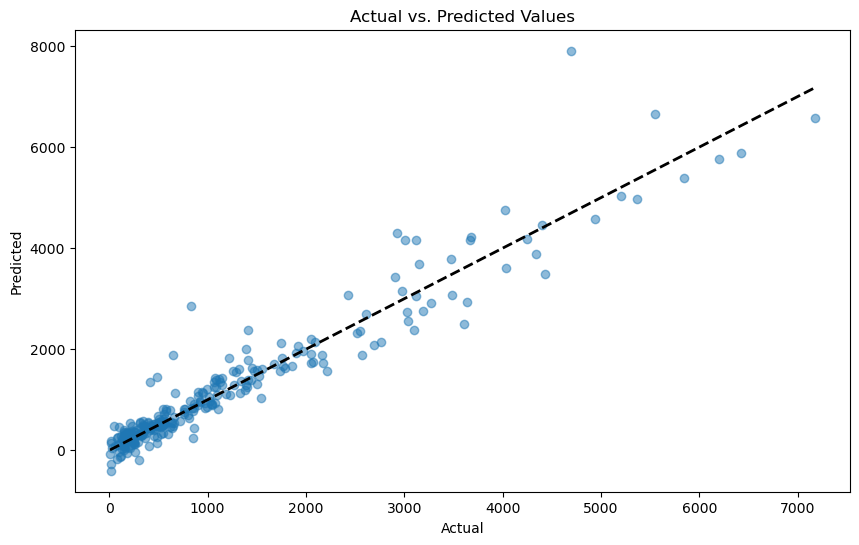

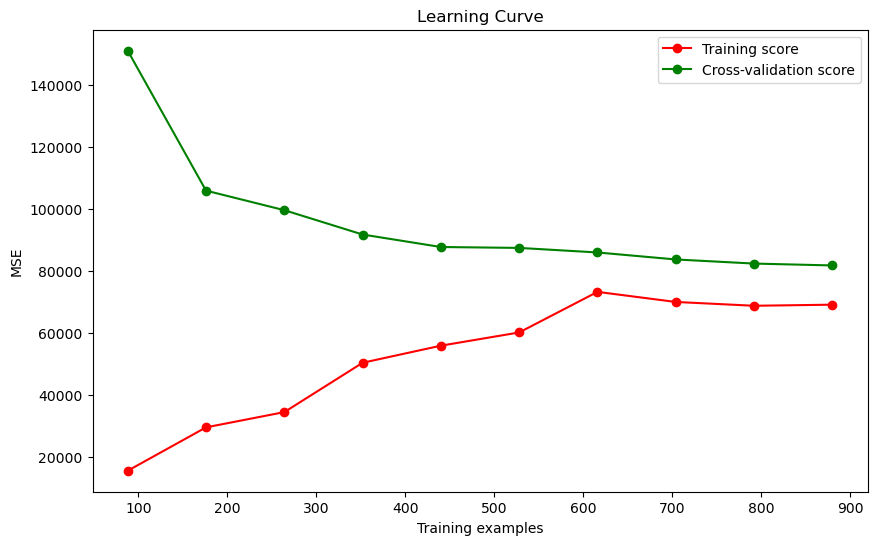

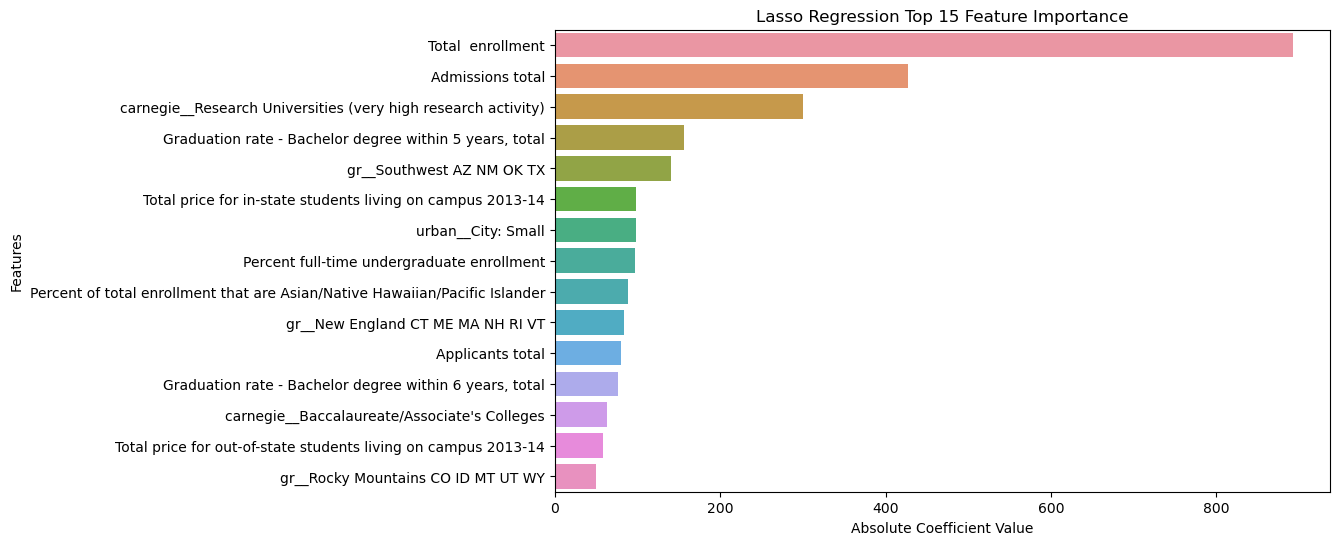

alpha  fit_intercept       tol        mse     mae    r2
0   0.74           True  1.19e-05  149954.89  223.15  0.91

In [49]:
print('Regression')
subset_split_data = {}

X = model_sets['Linear Regression'].drop(columns=['Name'], axis=1)
y = combination['Enrolled total']

# Perform the train-test split
subset_split_data['X_train'], subset_split_data['X_val'], subset_split_data['y_train'], subset_split_data['y_val'] = train_test_split(X, y, test_size=0.2, random_state=42)

reg_results = regression_optuna_tuning(subset_split_data)
reg = pd.DataFrame([reg_results['best_hyperparameters']])
reg['mse'] = reg_results['mse']
reg['mae'] = reg_results['mae']
reg['r2'] = reg_results['r2']
display(reg)


RF
Number of trials in the study: 191


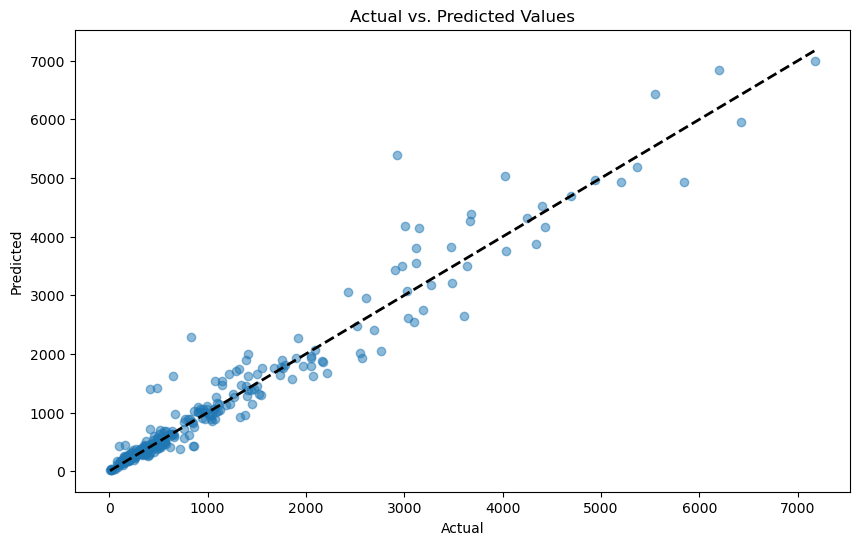

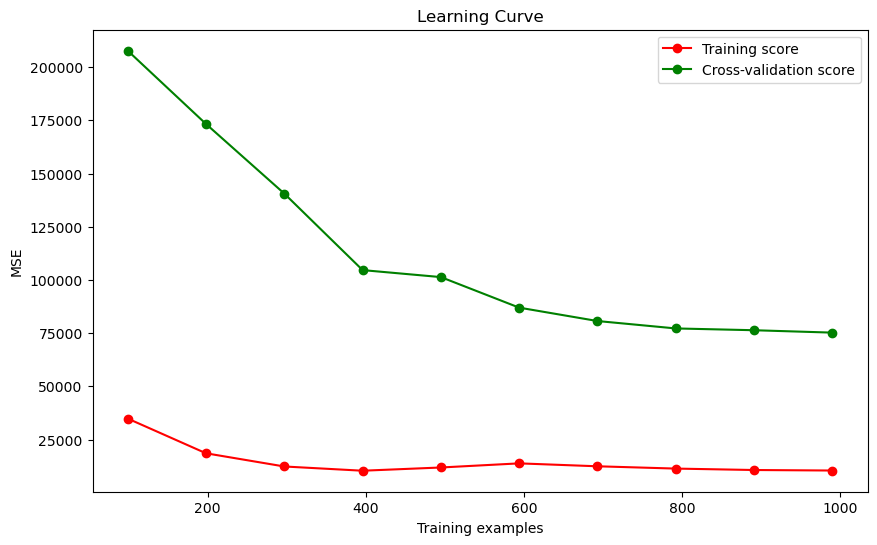

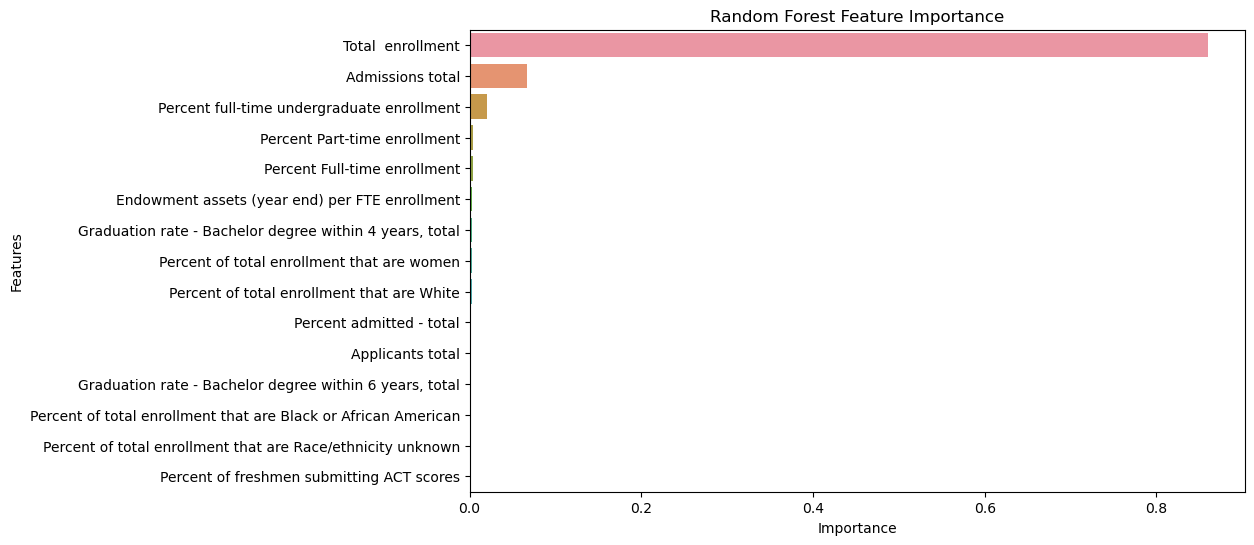

n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  \
0           945         16                  2                 1         None   

         mse     mae    r2  
0  101864.72  172.33  0.94

In [50]:
print('RF')

subset_split_data = {}

X = model_sets['Trees'].drop(columns=['Name'], axis=1)
y = combination['Enrolled total']

# Perform the train-test split
subset_split_data['X_train'], subset_split_data['X_val'], subset_split_data['y_train'], subset_split_data['y_val'] = train_test_split(X, y, test_size=0.2, random_state=42)

rf_results = randomforest_optuna_tuning(subset_split_data)
rf = pd.DataFrame([rf_results['best_hyperparameters']])
rf['mse'] = rf_results['mse']
rf['mae'] = rf_results['mae']
rf['r2'] = rf_results['r2']
display(rf)


XGB
Number of trials in the study: 250


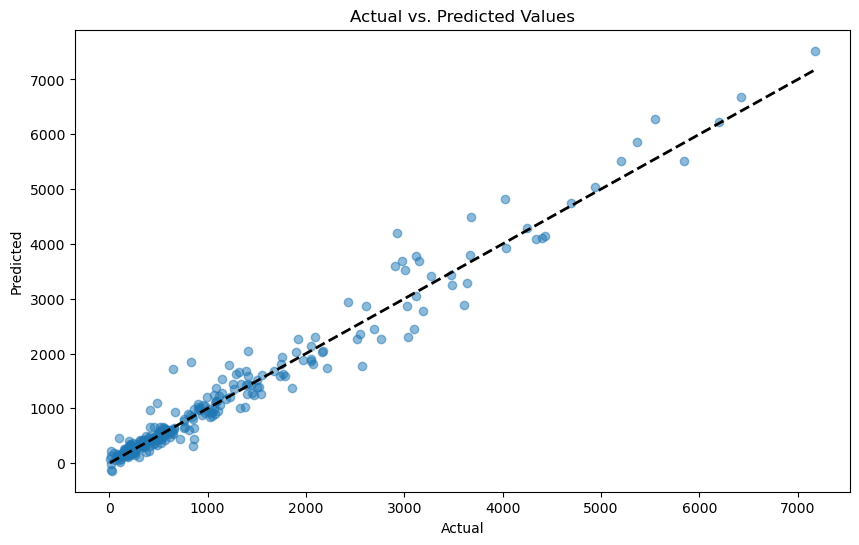

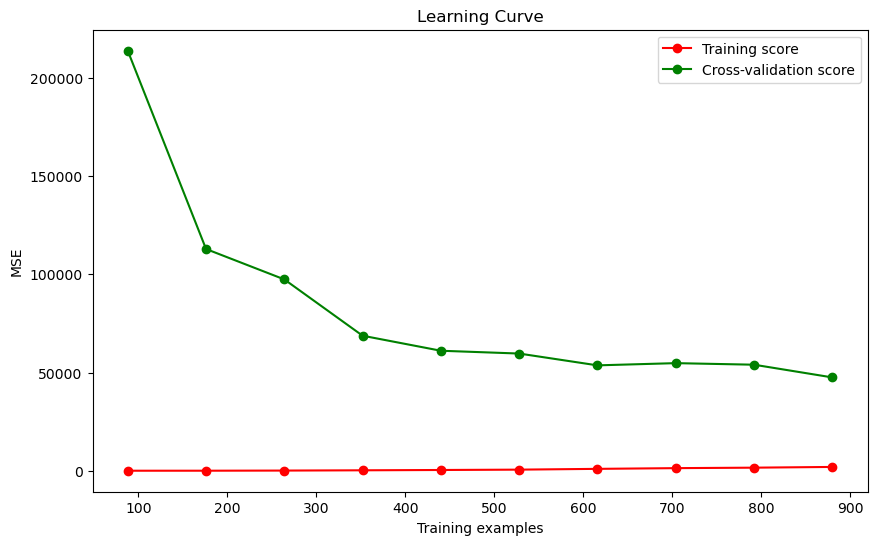

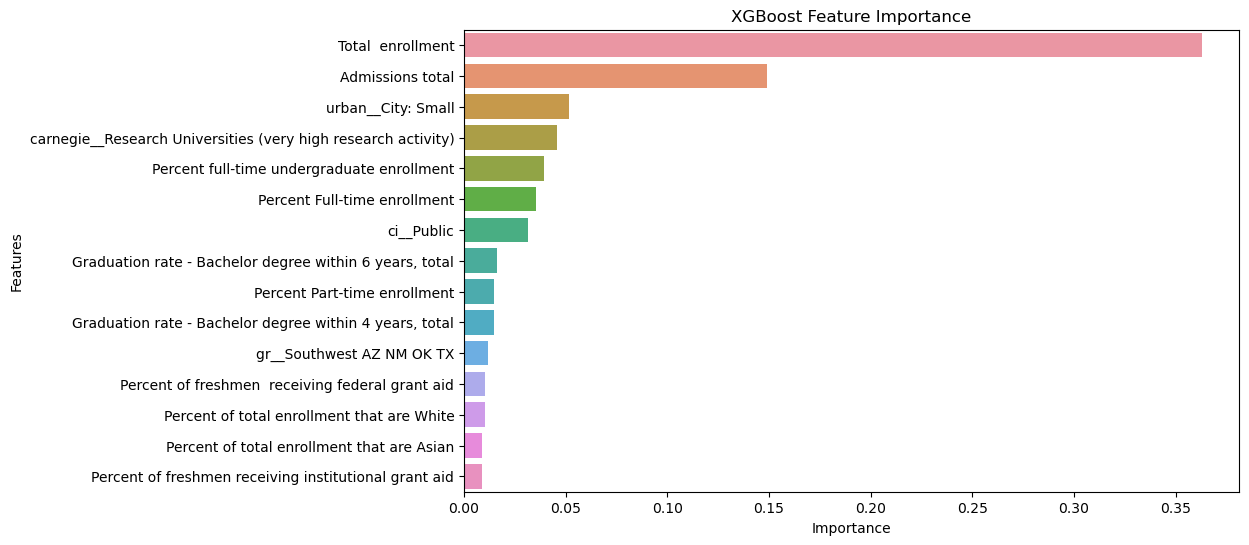

n_estimators  max_depth  learning_rate  subsample  colsample_bytree  gamma  \
0           926          3           0.04        0.5              0.98   0.58   

   reg_alpha  reg_lambda       mse     mae    r2  
0       5.12        0.68  62783.47  153.72  0.96

In [51]:
print('XGB')

subset_split_data = {}

X = model_sets['Trees'].drop(columns=['Name'], axis=1)
y = combination['Enrolled total']

# Perform the train-test split
subset_split_data['X_train'], subset_split_data['X_val'], subset_split_data['y_train'], subset_split_data['y_val'] = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_results = xgboost_optuna_tuning(subset_split_data)
xgb = pd.DataFrame([xgb_results['best_hyperparameters']])
xgb['mse'] = xgb_results['mse']
xgb['mae'] = xgb_results['mae']
xgb['r2'] = xgb_results['r2']
display(xgb)


FNN
Setting up Optuna study with pruner...
Number of trials in the study: 250
Epoch 1/250
35/35 [==============================] - 1s 7ms/step - loss: 2651899.2500 - val_loss: 2884469.5000
Epoch 2/250
35/35 [==============================] - 0s 2ms/step - loss: 2527826.2500 - val_loss: 2664414.0000
Epoch 3/250
35/35 [==============================] - 0s 2ms/step - loss: 2287274.2500 - val_loss: 2300257.7500
Epoch 4/250
35/35 [==============================] - 0s 2ms/step - loss: 1899704.7500 - val_loss: 1776541.3750
Epoch 5/250
35/35 [==============================] - 0s 2ms/step - loss: 1478774.2500 - val_loss: 1285916.2500
Epoch 6/250
35/35 [==============================] - 0s 2ms/step - loss: 1062596.1250 - val_loss: 850194.8125
Epoch 7/250
35/35 [==============================] - 0s 2ms/step - loss: 772217.1250 - val_loss: 589205.5000
Epoch 8/250
35/35 [==============================] - 0s 2ms/step - loss: 599863.0000 - val_loss: 462187.3750
Epoch 9/250
35/35 [====================

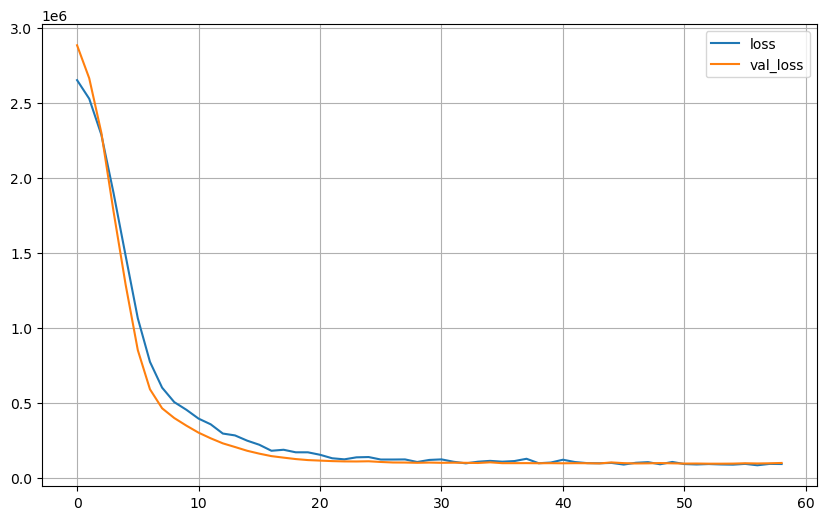

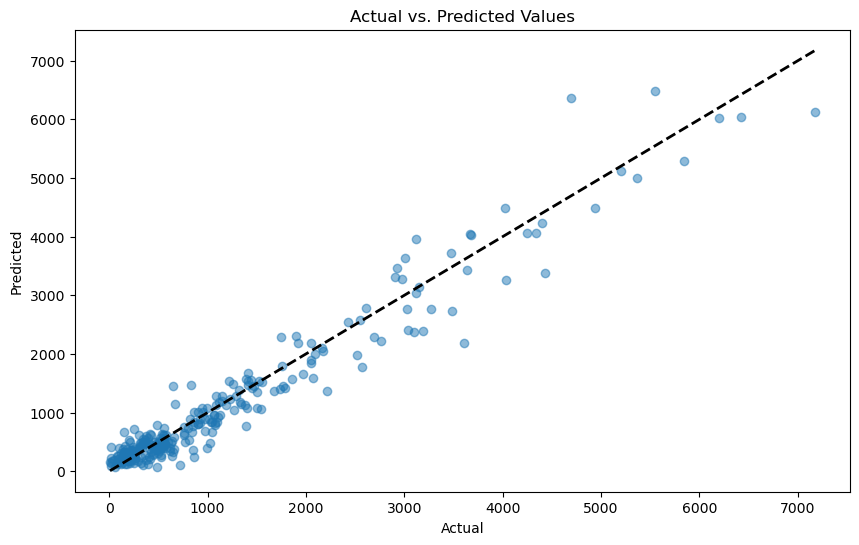

n_layers activation optimizer  units_layer_0  units_layer_1  \
0         2       relu   rmsprop             94            121   

   dropout_layer_1       mse     mae    r2  
0             0.42  97398.09  213.03  0.94

In [52]:
print('FNN')

subset_split_data = {}

X = model_sets['Feedforward Neural Network'].drop(columns=['Name'], axis=1)
y = combination['Enrolled total']

# Perform the train-test split
subset_split_data['X_train'], subset_split_data['X_val'], subset_split_data['y_train'], subset_split_data['y_val'] = train_test_split(X, y, test_size=0.2, random_state=42)

fnn_results = fnn_optuna_tuning(subset_split_data)
fnn = pd.DataFrame([fnn_results['best_hyperparameters']])
fnn['mse'] = fnn_results['mse']
fnn['mae'] = fnn_results['mae']
fnn['r2'] = fnn_results['r2']
display(fnn)
print('')

In [56]:
fnn['model'] = 'FNN'
xgb['model'] = 'XGB'
rf['model'] = 'RF'
reg['model'] = 'LASSO'

final_results = fnn[['model','mse','mae','r2']].copy()
final_results = pd.concat([final_results,xgb[['model','mse','mae','r2']]],axis=0)
final_results = pd.concat([final_results,rf[['model','mse','mae','r2']]],axis=0)
final_results = pd.concat([final_results,reg[['model','mse','mae','r2']]],axis=0)

final_results

model        mse     mae    r2
0    FNN   97398.09  213.03  0.94
0    XGB   62783.47  153.72  0.96
0     RF  101864.72  172.33  0.94
0  LASSO  149954.89  223.15  0.91